<a href="https://colab.research.google.com/github/ZahraFayyaz/2021-bordeaux-ODD/blob/main/attention_test_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## imports

In [ ]:
!pip install Sentencepiece
!pip install transformers #==4.18.0


In [ ]:
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sentencepiece
from transformers import TFDistilBertForMaskedLM, DistilBertConfig, AdamWeightDecay
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

path = Path('/content/drive/MyDrive/Data/div3/congruent').expanduser()
path.mkdir(parents=True, exist_ok=True)

mod0_train_x=np.load(path/'all_train_x.npy')
mod0_train_y=np.load(path/'all_train_y.npy')
mod0_test_x=np.load(path/'all_test_x.npy')
mod0_test_y=np.load(path/'all_test_y.npy')

mod0_x_train=np.load(path/'all_x_train.npy')
mod0_y_train=np.load(path/'all_train_labels.npy')
mod0_x_test=np.load(path/'all_x_test.npy')
mod0_y_test=np.load(path/'all_test_labels.npy')


In [ ]:
path = Path('/content/drive/MyDrive/Data/div3/incongruent').expanduser()
path.mkdir(parents=True, exist_ok=True)

mod1_train_x=np.load(path/'all_train_x.npy')
mod1_train_y=np.load(path/'all_train_y.npy')
mod1_test_x=np.load(path/'all_test_x.npy')
mod1_test_y=np.load(path/'all_test_y.npy')

mod1_x_train=np.load(path/'all_x_train.npy')
mod1_y_train=np.load(path/'all_train_labels.npy')
mod1_x_test=np.load(path/'all_x_test.npy')
mod1_y_test=np.load(path/'all_test_labels.npy')


# takeout specific data

In [ ]:
mod2_train_x=mod0_train_x[mod0_y_train%36==0]
mod2_train_y=mod0_train_y[mod0_y_train%36==0]
mod2_test_x=mod0_test_x[mod0_y_test%36==0]
mod2_test_y=mod0_test_y[mod0_y_test%36==0]


In [ ]:
mod2_x_train=mod0_x_train[mod0_y_train%36==0]
mod2_y_train=mod0_y_train[mod0_y_train%36==0]
mod2_x_test=mod0_x_test[mod0_y_test%36==0]
mod2_y_test=mod0_y_test[mod0_y_test%36==0]

In [ ]:
mod0_train_x=mod0_train_x[mod0_y_train %36 !=0]
mod0_train_y=mod0_train_y[mod0_y_train %36 !=0]
mod0_test_x=mod0_test_x[mod0_y_test %36 !=0]
mod0_test_y=mod0_test_y[mod0_y_test %36 !=0]

In [ ]:
mod0_x_train=mod0_x_train[mod0_y_train %36 !=0]
mod0_y_train=mod0_y_train[mod0_y_train %36 !=0]
mod0_x_test=mod0_x_test[mod0_y_test %36 !=0]
mod0_y_test=mod0_y_test[mod0_y_test %36 !=0]

### mask and condition functions

In [ ]:
def mask(train_x,mask_perc):
  n_samples=train_x.shape[0]
  n_tokens=np.prod(train_x.shape[1:3])
  mask_token=0
  flattenend_train_x=train_x.reshape((n_samples, n_tokens, train_x.shape[3]))
  mask = np.random.default_rng().choice([True, False], size=(n_samples, n_tokens), p=[mask_perc, 1 - mask_perc])
  masked_train_x = np.copy(flattenend_train_x)
  masked_train_x[mask] = mask_token
  return masked_train_x


def half_mask(train_x, mask_perc1, mask_perc2):
  n_samples=train_x.shape[0]
  n_tokens=np.prod(train_x.shape[1:3])
  mask_token=0
  flattenend_train_x=train_x.reshape((n_samples, n_tokens, train_x.shape[3]))
  mask1 = np.random.default_rng().choice([True, False], size=(n_samples, int(n_tokens/2)), p=[mask_perc1, 1 - mask_perc1])
  mask2 = np.random.default_rng().choice([True, False], size=(n_samples, int(n_tokens/2)), p=[mask_perc2, 1 - mask_perc2])
  mask = np.concatenate((mask1,mask2),axis=1)
  masked_train_x = np.copy(flattenend_train_x)
  masked_train_x[mask] = mask_token
  return masked_train_x


In [ ]:
def half_mask_data(train_x,mask_perc1,mask_perc2):
  n_samples=train_x.shape[0]
  n_tokens=np.prod(train_x.shape[1:3])
  mask_token=0
  flattenend_train_x=train_x.reshape((n_samples, n_tokens, train_x.shape[3]))
  mask1 = np.random.default_rng().choice([True, False], size=(n_samples, int(n_tokens/2)), p=[mask_perc1, 1 - mask_perc1])
  mask2 = np.random.default_rng().choice([True, False], size=(n_samples, int(n_tokens/2)), p=[mask_perc2, 1 - mask_perc2])

  masks1 = np.concatenate((mask1,mask2),axis=1)
  masks2 = np.concatenate((mask2,mask1),axis=1)
  indices= np.random.choice(a=[False, True], size=(n_samples), p=[0.5, 0.5])
  mask=masks1
  mask[indices]=masks2[indices]
  masked_train_x = np.copy(flattenend_train_x)
  masked_train_x[mask] = mask_token
  return masked_train_x

In [ ]:
mod0_masked_train_x=half_mask_data(mod0_train_x,0.1,0.9)
mod0_masked_test_x=half_mask_data(mod0_test_x,0.1,0.9)

In [ ]:
mod1_masked_train_x=half_mask_data(mod1_train_x,0.2,0.8)
mod1_masked_test_x=half_mask_data(mod1_test_x,0.2,0.8)

In [ ]:
data=half_mask_data(mod0_train_x,0.1,0.9)

## load base model

In [ ]:

n_train_samples, n_test_samples = mod0_train_x.shape[0], mod0_test_x.shape[0]
d_embed_vec = mod0_train_x.shape[3]
n_tokens = np.prod(mod0_train_x.shape[1:3])

indices = set(mod1_train_y.flatten()).union(set(mod1_test_y.flatten()))
indices = sorted(indices)
vocab_size = indices[-1] + 1


In [ ]:
mod0_train_y = mod0_train_y.reshape((mod0_train_y.shape[0], n_tokens))
mod0_test_y = mod0_test_y.reshape(( mod0_test_y.shape[0], n_tokens))

mod1_train_y = mod1_train_y.reshape((mod1_train_y.shape[0], n_tokens))
mod1_test_y = mod1_test_y.reshape(( mod1_test_y.shape[0], n_tokens))

In [ ]:
mod2_train_y = mod2_train_y.reshape((mod2_train_y.shape[0], n_tokens))
mod2_test_y = mod2_test_y.reshape(( mod2_test_y.shape[0], n_tokens))

##train and define transformer model

In [ ]:
d_batch = 256
n_epochs = 20
n_warmup_epochs = 10
lr = 0.001




cfg = DistilBertConfig(
    vocab_size=vocab_size,
    hidden_size=d_embed_vec,
    num_hidden_layers=4,
    num_attention_heads=2,
    intermediate_size=2048,
    max_position_embeddings=n_tokens
)


class LinearScheduleWithWarmup(tf.keras.optimizers.schedules.LearningRateSchedule):
    # How the schedule looks:
    # https://huggingface.co/transformers/v3.0.2/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup
    # or look at plot in testing section

    def __init__(self, learning_rate, n_warmup_epochs, n_train_samples, n_epochs, d_batch):
        self.learning_rate = tf.convert_to_tensor(learning_rate, dtype=tf.float32)
        self.n_warmup_epochs = tf.convert_to_tensor(n_warmup_epochs, dtype=tf.float32)
        self.n_train_samples = tf.convert_to_tensor(n_train_samples, dtype=tf.float32)
        self.n_epochs = tf.convert_to_tensor(n_epochs, dtype=tf.float32)
        self.d_batch = tf.convert_to_tensor(d_batch, dtype=tf.float32)

        self.steps_per_epoch = tf.convert_to_tensor(round(n_train_samples / d_batch), dtype=tf.float32)
        self.total_steps = tf.convert_to_tensor(self.steps_per_epoch * n_epochs, dtype=tf.float32)
        self.b = self.learning_rate * self.n_epochs / (self.n_epochs - self.n_warmup_epochs)

    def __call__(self, step):
        def true_fn():
            return self.learning_rate / self.n_warmup_epochs * step / self.steps_per_epoch
        def false_fn():
            return - self.learning_rate / (self.n_epochs - self.n_warmup_epochs) * (step / self.steps_per_epoch) + self.b

        ret = tf.cond(step / self.steps_per_epoch < self.n_warmup_epochs, true_fn, false_fn)
        return ret


model0 = TFDistilBertForMaskedLM(cfg)
lr_schedule = LinearScheduleWithWarmup(lr, n_warmup_epochs, n_train_samples, n_epochs, d_batch)
optimizer = AdamWeightDecay(lr=lr)#learning_rate=lr_schedule)

model0.compile(optimizer=optimizer)

model0({'inputs_embeds': mod0_masked_train_x[0, None], 'labels': mod0_train_y[0, None]})  # call model once with some input to get it built so we can do model.summary()
model0.summary()

Model: "tf_distil_bert_for_masked_lm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  1660672   
 inLayer)                                                        
                                                                 
 vocab_transform (Dense)     multiple                  4160      
                                                                 
 vocab_layer_norm (LayerNor  multiple                  128       
 malization)                                                     
                                                                 
 vocab_projector (TFDistilB  multiple                  7700      
 ertLMHead)                                                      
                                                                 
Total params: 1664980 (6.35 MB)
Trainable params: 1664980 (6.35 MB)
Non-trainable params: 0 (0.00 Byte

In [ ]:
model0.load_weights('/content/drive/MyDrive/div3heldoutsimmetrical4')

In [ ]:
weights_file_name = 'distilBERT_weights_conditional'
checkpoint_dir_name = 'mdl_checkpoints'

#if Path('distilBERT_weights').is_file():
#    load_status = model.load_weights('distilBERT_weights')
#    print('Continue training of pretrained model')

cpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'./{checkpoint_dir_name}/', save_weights_only=True, verbose=1)

# TODO: should we only penalize the reconstructed tokens in the loss and ignore the rest?
model0.fit({'inputs_embeds': mod0_masked_train_x, 'labels': mod0_train_y},
          batch_size=d_batch,
          epochs=n_epochs,
          #validation_data={'inputs_embeds': mod0_masked_test_x, 'labels': mod0_test_y},
          #callbacks=[cpt_callback]
          )

model0.save_weights('/content/drive/MyDrive/div3heldoutsimmetrical4', save_format='h5')

Epoch 1/20
145/145 [==============================] - 295s 2s/step - loss: 0.4594
Epoch 2/20
145/145 [==============================] - 297s 2s/step - loss: 0.4567
Epoch 3/20
145/145 [==============================] - 294s 2s/step - loss: 0.4551
Epoch 4/20
145/145 [==============================] - 297s 2s/step - loss: 0.4537
Epoch 5/20
145/145 [==============================] - 298s 2s/step - loss: 0.4528
Epoch 6/20
145/145 [==============================] - 300s 2s/step - loss: 0.4515
Epoch 7/20
145/145 [==============================] - 301s 2s/step - loss: 0.4508
Epoch 8/20
145/145 [==============================] - 301s 2s/step - loss: 0.4497
Epoch 9/20
145/145 [==============================] - 302s 2s/step - loss: 0.4490
Epoch 10/20
145/145 [==============================] - 302s 2s/step - loss: 0.4484
Epoch 11/20
145/145 [==============================] - 305s 2s/step - loss: 0.4482
Epoch 12/20
145/145 [==============================] - 300s 2s/step - loss: 0.4475
Epoch 13/20
1

In [ ]:
model0.evaluate({'inputs_embeds':  mod0_masked_test_x.astype('float32'), 'labels': mod0_test_y.astype('float32')}, batch_size=256)

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24/24 [==============================] - 32s 677ms/step - loss: 0.4571


0.4571410119533539

### load vqvae and classifier model

In [ ]:
import tensorflow.keras as K
from tensorflow.keras import backend as Kb
import matplotlib.pyplot as plt
from keras.models import load_model


def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train[..., None] / 255., y_train), (x_test[..., None] / 255., y_test)

(x_train, y_train), (x_test, y_test) = load_data('/content/drive/MyDrive/Data/mnist.npz')

# Hyperparameters
NUM_LATENT_K = 20                 # Number of codebook entries
NUM_LATENT_D = 64                 # Dimension of each codebook entries
BETA = 1.0                        # Weight for the commitment loss

INPUT_SHAPE = x_train.shape[1:]
SIZE = None                       # Spatial size of latent embedding
                                  # will be set dynamically in `build_vqvae

VQVAE_BATCH_SIZE = 128            # Batch size for training the VQVAE
VQVAE_NUM_EPOCHS = 20             # Number of epochs
VQVAE_LEARNING_RATE = 3e-4        # Learning rate
VQVAE_LAYERS = [16, 32]           # Number of filters for each layer in the encoder

PIXELCNN_BATCH_SIZE = 128         # Batch size for training the PixelCNN prior
PIXELCNN_NUM_EPOCHS = 10          # Number of epochs
PIXELCNN_LEARNING_RATE = 3e-4     # Learning rate
PIXELCNN_NUM_BLOCKS = 12          # Number of Gated PixelCNN blocks in the architecture
PIXELCNN_NUM_FEATURE_MAPS = 32    # Width of each PixelCNN block


# # Building the generative model
#
# The first step is to build the main VQ-VAE model. It consists of a standard encoder-decoder architecture with convolutional blocks. The main novelty lies in the intermediate **Vector Quantizer** layer (`VQ`) that takes care of building a **discrete** latent space.
#
# More specifically, the encoder, `f` is a fully-convolutional neural network that maps input images to latent codes of size $(w, h, d)$, where $d$ is the dimension of the latent space, and $w \times h$ the size of the final feature map. The output of the encoder is then mapped to the closest entry in a discrete **codebook** of $K$ latent codes, $\mathcal E = \{e_0 \dots e_{K-1} \}$ where $\forall i, e_i \in \mathbb{R}^d$.
#
# \begin{align}
# &\textbf{input }x \tag{W x H x C}\\
# z_e &= f(x) \tag{w x h x d}\\
# z_q^{i, j} &= \arg\min_{e \in \mathcal E} \| z_e^{i, j} - e \|^2
# \end{align}
#
# The Vector Quantization process is implemented as the following `Keras` Layer:

# In[7]:


class VectorQuantizer(K.layers.Layer):
    def __init__(self, k, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.k = k

    def build(self, input_shape):
        self.d = int(input_shape[-1])
        rand_init = K.initializers.VarianceScaling(distribution="uniform")
        self.codebook = self.add_weight(shape=(self.k, self.d), initializer=rand_init, trainable=True)

    def call(self, inputs):
        # Map z_e of shape (b, w,, h, d) to indices in the codebook
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        z_e = tf.expand_dims(inputs, -2)
        dist = tf.norm(z_e - lookup_, axis=-1)
        k_index = tf.argmin(dist, axis=-1)
        return k_index

    def sample(self, k_index):
        # Map indices array of shape (b, w, h) to actual codebook z_q
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        k_index_one_hot = tf.one_hot(k_index, self.k)
        z_q = lookup_ * k_index_one_hot[..., None]
        z_q = tf.reduce_sum(z_q, axis=-2)
        return z_q


# The decoder, $g$, then takes the quantized codes $z_q$ as inputs and generates the output image. Here we consider a simple architecture with transposed convolution blocks, mirroring the encoder architecture:

# In[8]:


def encoder_pass(inputs, d, num_layers=[16, 32]):
    x = inputs
    for i, filters in enumerate(num_layers):
        x = K.layers.Conv2D(filters=filters, kernel_size=3, padding='SAME', activation='relu',
                            strides=(2, 2), name="conv{}".format(i + 1))(x)
    z_e = K.layers.Conv2D(filters=d, kernel_size=3, padding='SAME', activation=None,
                          strides=(1, 1), name='z_e')(x)
    return z_e

def decoder_pass(inputs, num_layers=[32, 16]):
    y = inputs
    for i, filters in enumerate(num_layers):
        y = K.layers.Conv2DTranspose(filters=filters, kernel_size=4, strides=(2, 2), padding="SAME",
                                     activation='relu', name="convT{}".format(i + 1))(y)
    decoded = K.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1),
                                       padding="SAME", activation='sigmoid', name='output')(y)
    return decoded


# Once these three building blocks are done, we can build the full `VQ-VAE`. One subtility is how we can estimate gradient through the Vector Quantizer: In fact, the transition from $z_e$ to $z_q$ does not allow to backpropagate gradient due to the argmin function. Instead, the authors propose to use a *straight-through estimator*, that directly copies the gradient received by $z_q$ to $z_e$.

# In[9]:


def build_vqvae(k, d, input_shape=(28, 28, 1), num_layers=[16, 32]):
    global SIZE
    ## Encoder
    encoder_inputs = K.layers.Input(shape=input_shape, name='encoder_inputs')
    z_e = encoder_pass(encoder_inputs, d, num_layers=num_layers)
    SIZE = int(z_e.get_shape()[1])

    ## Vector Quantization
    vector_quantizer = VectorQuantizer(k, name="vector_quantizer")
    codebook_indices = vector_quantizer(z_e)
    encoder = K.Model(inputs=encoder_inputs, outputs=codebook_indices, name='encoder')

    ## Decoder
    decoder_inputs = K.layers.Input(shape=(SIZE, SIZE, d), name='decoder_inputs')
    decoded = decoder_pass(decoder_inputs, num_layers=num_layers[::-1])
    decoder = K.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')

    ## VQVAE Model (training)
    sampling_layer = K.layers.Lambda(lambda x: vector_quantizer.sample(x), name="sample_from_codebook")
    z_q = sampling_layer(codebook_indices)
    codes = tf.stack([z_e, z_q], axis=-1)
    codes = K.layers.Lambda(lambda x: x, name='latent_codes')(codes)
    straight_through = K.layers.Lambda(lambda x : x[1] + tf.stop_gradient(x[0] - x[1]), name="straight_through_estimator")
    straight_through_zq = straight_through([z_q, z_e])
    reconstructed = decoder(straight_through_zq)
    vq_vae = K.Model(inputs=encoder_inputs, outputs=[reconstructed, codes], name='vq-vae')

    ## VQVAE model (inference)
    codebook_indices = K.layers.Input(shape=(SIZE, SIZE), name='discrete_codes', dtype=tf.int32)
    z_q = sampling_layer(codebook_indices)
    generated = decoder(z_q)
    vq_vae_sampler = K.Model(inputs=codebook_indices, outputs=generated, name='vq-vae-sampler')

    ## Transition from codebook indices to model (for training the prior later)
    indices = K.layers.Input(shape=(SIZE, SIZE), name='codes_sampler_inputs', dtype='int32')
    z_q = sampling_layer(indices)
    codes_sampler = K.Model(inputs=indices, outputs=z_q, name="codes_sampler")

    ## Getter to easily access the codebook for vizualisation
    indices = K.layers.Input(shape=(), dtype='int32')
    vector_model = K.Model(inputs=indices, outputs=vector_quantizer.sample(indices[:, None, None]), name='get_codebook')
    def get_vq_vae_codebook():
        codebook = vector_model.predict(np.arange(k))
        codebook = np.reshape(codebook, (k, d))
        return codebook

    return vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook

vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook = build_vqvae(
    NUM_LATENT_K, NUM_LATENT_D, input_shape=INPUT_SHAPE, num_layers=VQVAE_LAYERS)
vq_vae.summary()

def mse_loss(ground_truth, predictions):
    mse_loss = tf.reduce_mean((ground_truth - predictions)**2, name="mse_loss")
    return mse_loss

def latent_loss(dummy_ground_truth, outputs):
    global BETA
    del dummy_ground_truth
    z_e, z_q = tf.split(outputs, 2, axis=-1)
    vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
    commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
    latent_loss = tf.identity(vq_loss + BETA * commit_loss, name="latent_loss")
    return latent_loss
vq_vae.load_weights('/content/drive/MyDrive/Data/vq20_ws.h5')


The following Variables were used a Lambda layer's call (sample_from_codebook), but
are not present in its tracked objects:
  <tf.Variable 'vector_quantizer/Variable:0' shape=(20, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "vq-vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 28, 28, 1)]          0         []                            
 )                                                                                                
                                                                                                  
 conv1 (Conv2D)              (None, 14, 14, 16)           160       ['encoder_inputs[0][0]']      
                                                                                                  
 conv2 (Conv2D)              (None, 7, 7, 32)             4640      ['conv1[0][0]']               
                                                                                                  
 z_e (Conv2D)                (None, 7, 7, 64)             18496     ['conv2[0][0]']          

In [ ]:
from keras.models import load_model
classifier = load_model('/content/drive/MyDrive/Data/MNIST_keras_CNN.h5')

In [ ]:
#redo the code sampler in numpy
codebooks=codes_sampler(np.arange(20))
codebooks=np.array(codebooks).reshape(20,64)

## test the model

In [ ]:
def decode(most_probable, codes_sampler):
  codes= most_probable.reshape([most_probable.shape[0],14,7])
  codes1=codes[:,:7,:]
  codes2=codes[:,7:,:]
  zq1 = codes_sampler(codes1)
  zq2 = codes_sampler(codes2)
  decoded1 = decoder.predict(zq1, steps=1)
  decoded2 = decoder.predict(zq2, steps=1)
  return decoded1, decoded2

def plot_decode(decoded1, decoded2,x_test, size, n_row, n_col):
    """plot decoded codes"""
    n = n_col * n_row
    plt.figure(figsize=(14, 5))
    for i in range(n):
        plt.subplot(n_row, 3 * n_col, 3 * i + 1)
        plt.imshow(x_test[i], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 3 * n_col, 3 * i + 2)
        #plt.subplots_adjust(hpad=0.01)
        plt.imshow(np.vstack((decoded1[i,:,:,0],decoded2[i,:,:,0])), cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 3 * n_col, 3 * i + 3)
        plt.imshow(np.zeros((56,28)), cmap='binary')
        plt.axis('off')
        #plt.tight_layout()
    plt.show()


In [ ]:
n_rec = 100

# see https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.MaskedLMOutput
reconstructions = model0.predict({'inputs_embeds': mod1_masked_test_x[:n_rec].astype('float32'), 'labels': mod1_test_y[:n_rec].astype('float32')}, batch_size=256)

logits = reconstructions.logits
most_probable = logits.argmax(axis=-1)

1/1 [==============================] - 10s 10s/step


1/1 [==============================] - 0s 34ms/step


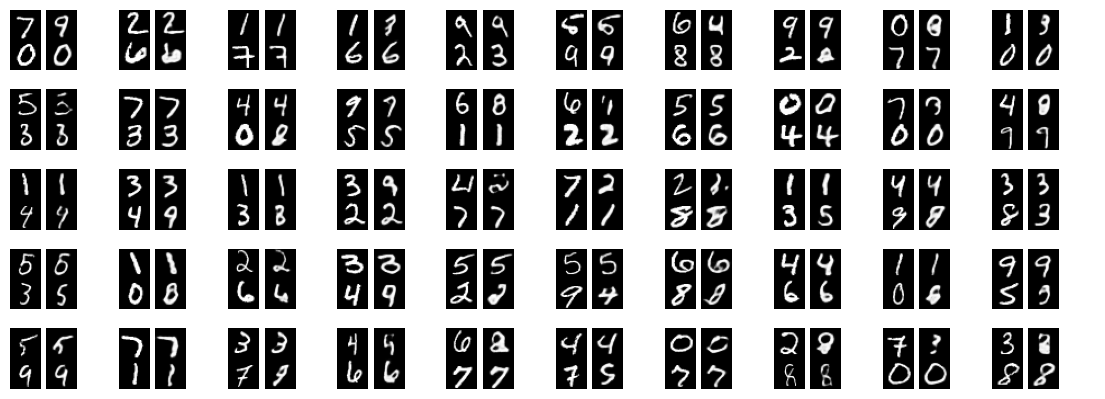

In [ ]:

decoded1, decoded2 = decode(most_probable, codes_sampler)
plot_decode(decoded1, decoded2,mod1_x_test[:100,:,:,0], 100,5,10)

## attention based completion (By fatemeh)



In [ ]:
### Congruent
def decode_Full(most_probable, codes_sampler):
  codes= most_probable.reshape([most_probable.shape[0],14,7])
  codes1=codes[:,:7,:]
  codes2=codes[:,7:,:]
  zq1 = codes_sampler(codes1)
  zq2 = codes_sampler(codes2)
  decoded1 = decoder.predict(zq1, steps=1)
  decoded2 = decoder.predict(zq2, steps=1)
  return decoded1, decoded2


n_rec = 10

# Plot Full part of digit in 0 percent of Mask
Main_input_0Percent = mod0_x_test[:n_rec]

# Set up the percentage mask values
mask_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Store decoded results in a dictionary for easy access
decoded_results = {}

# Loop through each mask percentage
for percent in mask_percentages:

    # Apply the mask to the Full part of the digits
    masked_test_x = mask(mod0_test_x[:n_rec], percent)

    # Perform the model prediction
    reconstructions = model0.predict({'inputs_embeds': masked_test_x, 'labels': mod0_test_y[n_rec:2*n_rec]}, batch_size=256)

    # Extract the logits and determine the most probable predictions
    logits = reconstructions.logits
    most_probable = logits.argmax(axis=-1)

    # Decode the most probable predictions and store the results
    decoded_results[percent] = decode_Full(most_probable, codes_sampler)



# Set up the number of rows and columns for the subplot grid
n_row = 9
n_col = 10
n = n_col * n_row
plt.figure(figsize=(14, 5))

# Initialize index for tracking which image to plot
indices = 0

# Loop through each subplot position
for i in range(n):
    plt.subplot(n_row, n_col, i + 1)

    # Determine which image to plot based on the column index
    col_idx = i % 10

    if col_idx == 0:
        # Plot the original unmasked image
        first_part = Main_input_0Percent[indices][:28, :]
        second_part = Main_input_0Percent[indices][28:, :]
        concatenated = np.hstack((first_part, second_part))
        plt.imshow(concatenated, cmap='gray')
        plt.axis('off')
        if indices == 0:
            plt.title("Original Image")  # Label for the first column
    elif 1 <= col_idx <= 9:
        # Plot the decoded image for each corresponding mask percentage
        percent = mask_percentages[col_idx - 1]  # Mapping from col_idx to mask percentage
        first_part, second_part = decoded_results[percent]
        concatenated = np.hstack((first_part[indices, :, :, 0], second_part[indices, :, :, 0]))
        plt.imshow(concatenated, cmap='gray')
        plt.axis('off')
        if indices == 0:
            plt.title(f"{percent*100:.0f}% Mask")  # Label for the mask percentage columns

    # Increment the index at the start of each row
    if col_idx == 9:
        indices += 1

plt.tight_layout()
plt.show()


1/1 [==============================] - 2s 2s/step


NameError: name 'codes_sampler' is not defined

1/1 [==============================] - 0s 25ms/step


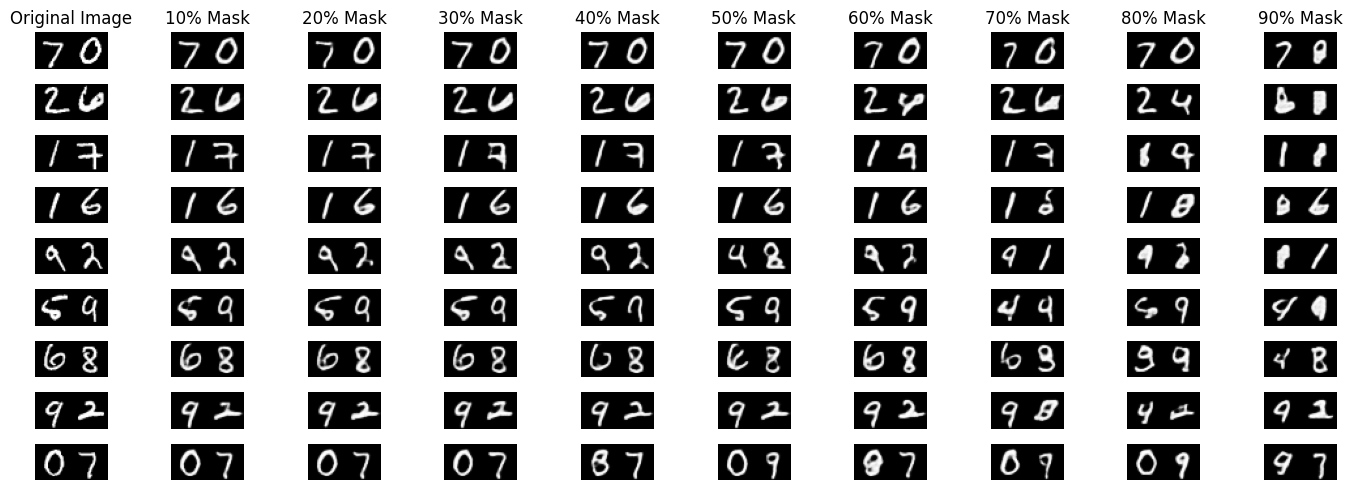

In [ ]:
###incongruent
def decode_Full(most_probable, codes_sampler):
  codes= most_probable.reshape([most_probable.shape[0],14,7])
  codes1=codes[:,:7,:]
  codes2=codes[:,7:,:]
  zq1 = codes_sampler(codes1)
  zq2 = codes_sampler(codes2)
  decoded1 = decoder.predict(zq1, steps=1)
  decoded2 = decoder.predict(zq2, steps=1)
  return decoded1, decoded2


n_rec = 10

# Plot Full part of digit in 0 percent of Mask
Main_input_0Percent = mod1_x_test[:n_rec]

# Set up the percentage mask values
mask_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Store decoded results in a dictionary for easy access
decoded_results = {}

# Loop through each mask percentage
for percent in mask_percentages:

    # Apply the mask to the Full part of the digits
    masked_test_x = mask(mod1_test_x[:n_rec], percent)

    # Perform the model prediction
    reconstructions = model0.predict({'inputs_embeds': masked_test_x, 'labels': mod0_test_y[n_rec:2*n_rec]}, batch_size=256)

    # Extract the logits and determine the most probable predictions
    logits = reconstructions.logits
    most_probable = logits.argmax(axis=-1)

    # Decode the most probable predictions and store the results
    decoded_results[percent] = decode_Full(most_probable, codes_sampler)



# Set up the number of rows and columns for the subplot grid
n_row = 9
n_col = 10
n = n_col * n_row
plt.figure(figsize=(14, 5))

# Initialize index for tracking which image to plot
indices = 0

# Loop through each subplot position
for i in range(n):
    plt.subplot(n_row, n_col, i + 1)

    # Determine which image to plot based on the column index
    col_idx = i % 10

    if col_idx == 0:
        # Plot the original unmasked image
        first_part = Main_input_0Percent[indices][:28, :]
        second_part = Main_input_0Percent[indices][28:, :]
        concatenated = np.hstack((first_part, second_part))
        plt.imshow(concatenated, cmap='gray')
        plt.axis('off')
        if indices == 0:
            plt.title("Original Image")  # Label for the first column
    elif 1 <= col_idx <= 9:
        # Plot the decoded image for each corresponding mask percentage
        percent = mask_percentages[col_idx - 1]  # Mapping from col_idx to mask percentage
        first_part, second_part = decoded_results[percent]
        concatenated = np.hstack((first_part[indices, :, :, 0], second_part[indices, :, :, 0]))
        plt.imshow(concatenated, cmap='gray')
        plt.axis('off')
        if indices == 0:
            plt.title(f"{percent*100:.0f}% Mask")  # Label for the mask percentage columns

    # Increment the index at the start of each row
    if col_idx == 9:
        indices += 1

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 24ms/step


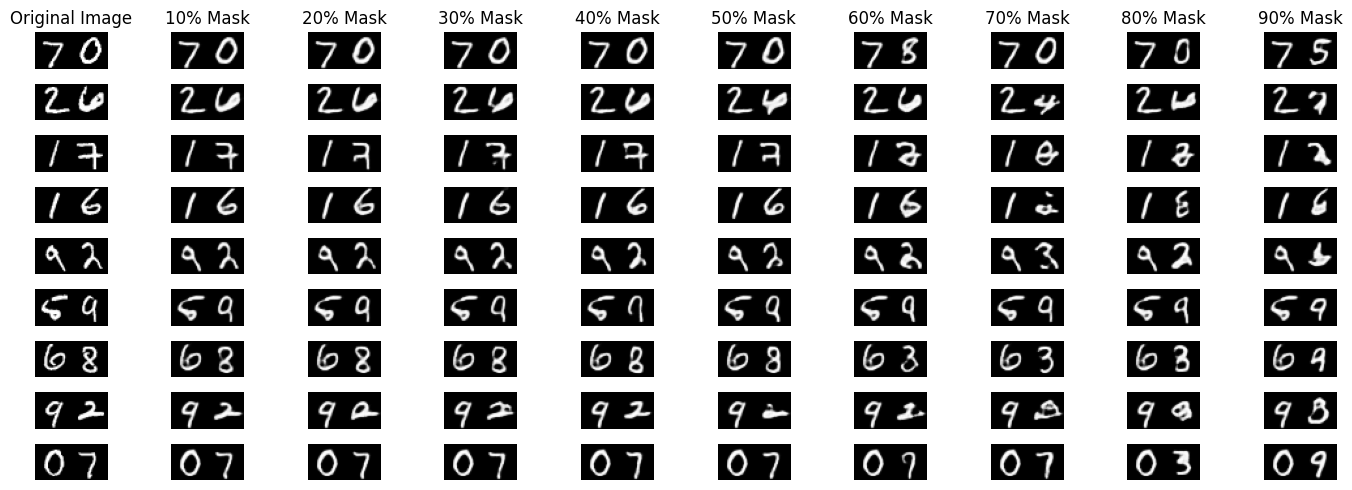

In [ ]:
#Half mask

def decode_Full(most_probable, codes_sampler):
  codes= most_probable.reshape([most_probable.shape[0],14,7])
  codes1=codes[:,:7,:]
  codes2=codes[:,7:,:]
  zq1 = codes_sampler(codes1)
  zq2 = codes_sampler(codes2)
  decoded1 = decoder.predict(zq1, steps=1)
  decoded2 = decoder.predict(zq2, steps=1)
  return decoded1, decoded2


n_rec = 10

# Plot Full part of digit in 0 percent of Mask
Main_input_0Percent = mod1_x_test[:n_rec]

# Set up the percentage mask values
mask_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Store decoded results in a dictionary for easy access
decoded_results = {}

# Loop through each mask percentage
for percent in mask_percentages:

    # Apply the mask to the Full part of the digits
    masked_test_x = half_mask(mod1_test_x[:n_rec],0, percent)

    # Perform the model prediction
    reconstructions = model0.predict({'inputs_embeds': masked_test_x, 'labels': mod0_test_y[n_rec:2*n_rec]}, batch_size=256)

    # Extract the logits and determine the most probable predictions
    logits = reconstructions.logits
    most_probable = logits.argmax(axis=-1)

    # Decode the most probable predictions and store the results
    decoded_results[percent] = decode_Full(most_probable, codes_sampler)



# Set up the number of rows and columns for the subplot grid
n_row = 9
n_col = 10
n = n_col * n_row
plt.figure(figsize=(14, 5))

# Initialize index for tracking which image to plot
indices = 0

# Loop through each subplot position
for i in range(n):
    plt.subplot(n_row, n_col, i + 1)

    # Determine which image to plot based on the column index
    col_idx = i % 10

    if col_idx == 0:
        # Plot the original unmasked image
        first_part = Main_input_0Percent[indices][:28, :]
        second_part = Main_input_0Percent[indices][28:, :]
        concatenated = np.hstack((first_part, second_part))
        plt.imshow(concatenated, cmap='gray')
        plt.axis('off')
        if indices == 0:
            plt.title("Original Image")  # Label for the first column
    elif 1 <= col_idx <= 9:
        # Plot the decoded image for each corresponding mask percentage
        percent = mask_percentages[col_idx - 1]  # Mapping from col_idx to mask percentage
        first_part, second_part = decoded_results[percent]
        concatenated = np.hstack((first_part[indices, :, :, 0], second_part[indices, :, :, 0]))
        plt.imshow(concatenated, cmap='gray')
        plt.axis('off')
        if indices == 0:
            plt.title(f"{percent*100:.0f}% Mask")  # Label for the mask percentage columns

    # Increment the index at the start of each row
    if col_idx == 9:
        indices += 1

plt.tight_layout()
plt.show()


 ## Masking effect (randowm attemtion)

In [ ]:
from tqdm import tqdm


In [ ]:
def masking_effect(model,test_x,test_y,y_test,Congruency=True, Half_mask=True,held_out=False):
  mask_levels=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
  n = len(mask_levels)
  error1 = np.zeros(n)
  error2 = np.zeros(n)
  errors_total = np.zeros(n)
  evals=np.zeros(n)
  semantic_error=np.zeros(n)

  for i in tqdm(range(n)):
    mask_perc=mask_levels[i]
    if Half_mask:
      masked_test_x=half_mask(test_x,0,mask_perc)
      mskttl='Half mask'
    else:
      masked_test_x=mask(test_x,mask_perc)
      mskttl='Full mask'
    reconstructions = model.predict({'inputs_embeds': masked_test_x.astype('float32'), 'labels': test_y.astype('float32')}, batch_size=256)
    logits = reconstructions.logits
    most_probable = logits.argmax(axis=-1)
    decoded1, decoded2 = decode(most_probable, codes_sampler)
    class1=classifier.predict(decoded1).argmax(axis=-1)
    class2=classifier.predict(decoded2).argmax(axis=-1)
    error1[i]= (class1 != y_test//10).mean()
    error2[i]= (class2 != y_test%10).mean()
    errors_total[i] = (class1*10 + class2 != y_test).mean()
    if Congruency:
      congttl='Congruent'
      semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0) & (class1*10 + class2 != 0)).mean()
    elif Congruency or not held_out:
      semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0)& (class1*10 + class2 != 0)).mean()
      congttl='Incongruent'
    elif held_out:
      semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0)& (class1*10 + class2 != 0)).mean()
      congttl='Congruent heldout'

    evals[i]=model.evaluate({'inputs_embeds': masked_test_x.astype('float32'), 'labels': test_y.astype('float32')}, batch_size=256)
    Title=mskttl+','+congttl

  return error1, error2, errors_total, semantic_error, evals, Title


In [ ]:
error1tf, error2tf, errors_totaltf, semantic_errortf, evalstf , Titletf= masking_effect(model0,mod0_test_x,mod0_test_y,mod0_y_test,Congruency=True, Half_mask=False)

  0%|          | 0/12 [00:00<?, ?it/s]

24/24 [==============================] - 16s 664ms/step - loss: 1.5530e-04


  8%|▊         | 1/12 [00:36<06:39, 36.35s/it]

24/24 [==============================] - 16s 665ms/step - loss: 0.0589


 17%|█▋        | 2/12 [01:12<06:02, 36.26s/it]

24/24 [==============================] - 16s 677ms/step - loss: 0.1212


 25%|██▌       | 3/12 [01:49<05:27, 36.44s/it]

24/24 [==============================] - 16s 662ms/step - loss: 0.1892


 33%|███▎      | 4/12 [02:25<04:50, 36.28s/it]

24/24 [==============================] - 16s 670ms/step - loss: 0.2659


 42%|████▏     | 5/12 [03:01<04:14, 36.29s/it]

24/24 [==============================] - 16s 675ms/step - loss: 0.3530


 50%|█████     | 6/12 [03:37<03:37, 36.26s/it]

24/24 [==============================] - 16s 664ms/step - loss: 0.4505


 58%|█████▊    | 7/12 [04:13<03:00, 36.17s/it]

24/24 [==============================] - 16s 670ms/step - loss: 0.5789


 67%|██████▋   | 8/12 [04:49<02:24, 36.16s/it]

24/24 [==============================] - 16s 672ms/step - loss: 0.7435


 75%|███████▌  | 9/12 [05:26<01:48, 36.22s/it]

24/24 [==============================] - 16s 659ms/step - loss: 0.9592


 83%|████████▎ | 10/12 [06:02<01:12, 36.16s/it]

24/24 [==============================] - 16s 670ms/step - loss: 1.0812


 92%|█████████▏| 11/12 [06:38<00:36, 36.25s/it]

24/24 [==============================] - 16s 665ms/step - loss: 1.1518


100%|██████████| 12/12 [07:14<00:00, 36.25s/it]


In [ ]:
def plot_error(error1, error2, errors_total, semantic_error, evals, Title):
  mask_levels=[0, 10,20,30,40,50,60,70,80,90,95,99]
  plt.plot(mask_levels,error1, label='first digit',)
  plt.plot(mask_levels,error2, label='second digit')
  plt.plot(mask_levels,errors_total, label='total')
  plt.plot(mask_levels,evals, label='loss')
  plt.plot(mask_levels,semantic_error, label='semantic error')
  plt.xlabel('percent masked')
  plt.ylabel('error rate')
  plt.title(Title)
  plt.xticks(mask_levels,mask_levels)
  plt.ylim(0,1)
  plt.grid()
  plt.legend()
  plt.show()

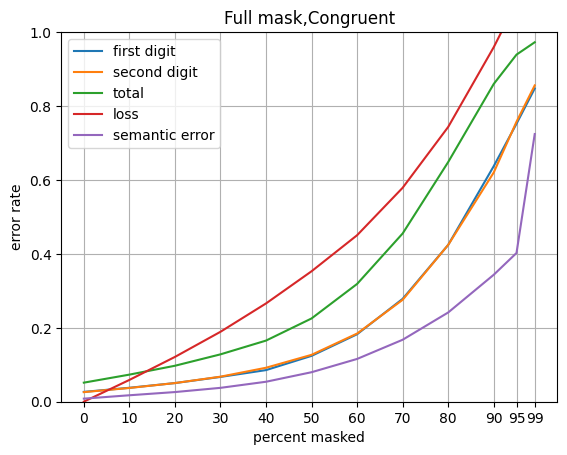

In [ ]:
plot_error(error1tf, error2tf, errors_totaltf, semantic_errortf, evalstf, Titletf)

In [ ]:
mask_levels=[0, 10,20,30,40,50,60,70,80,90,95,99]
plt.plot(mask_levels,error1cf, label='first digit',)
plt.plot(mask_levels,error2cf, label='second digit')
plt.plot(mask_levels,errors_totalcf, label='total')
plt.plot(mask_levels,evals, label='loss')
plt.plot(mask_levels,semantic_errorcf, label='semantic error')
plt.xlabel('percent masked')
plt.ylabel('error rate')
plt.title(Titlecf)
plt.xticks(mask_levels,mask_levels)
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

NameError: name 'error1cf' is not defined

In [ ]:
error1ff, error2ff, errors_totalff, semantic_errorff, evalsff , Titleff= masking_effect(model0,mod1_test_x[:500],mod1_test_y[:500],mod1_y_test[:500],Congruency=False, Half_mask=False)

  0%|          | 0/12 [00:00<?, ?it/s]

2/2 [==============================] - 1s 691ms/step - loss: 9.8688e-06


  8%|▊         | 1/12 [00:03<00:38,  3.46s/it]

2/2 [==============================] - 1s 665ms/step - loss: 0.0632


 17%|█▋        | 2/12 [00:06<00:34,  3.46s/it]

2/2 [==============================] - 1s 649ms/step - loss: 0.1261


 25%|██▌       | 3/12 [00:10<00:31,  3.46s/it]

2/2 [==============================] - 1s 641ms/step - loss: 0.2012


 33%|███▎      | 4/12 [00:13<00:27,  3.41s/it]

2/2 [==============================] - 1s 639ms/step - loss: 0.2894


 42%|████▏     | 5/12 [00:17<00:23,  3.39s/it]

2/2 [==============================] - 1s 651ms/step - loss: 0.3742


 50%|█████     | 6/12 [00:20<00:20,  3.38s/it]

2/2 [==============================] - 1s 638ms/step - loss: 0.4887


 58%|█████▊    | 7/12 [00:23<00:16,  3.39s/it]

2/2 [==============================] - 1s 633ms/step - loss: 0.6149


 67%|██████▋   | 8/12 [00:27<00:13,  3.37s/it]

2/2 [==============================] - 1s 640ms/step - loss: 0.7879


 75%|███████▌  | 9/12 [00:30<00:10,  3.36s/it]

2/2 [==============================] - 1s 642ms/step - loss: 0.9727


 83%|████████▎ | 10/12 [00:33<00:06,  3.36s/it]

2/2 [==============================] - 1s 627ms/step - loss: 1.0833


 92%|█████████▏| 11/12 [00:37<00:03,  3.35s/it]

2/2 [==============================] - 1s 631ms/step - loss: 1.1466


100%|██████████| 12/12 [00:40<00:00,  3.37s/it]


In [ ]:
plot_error(error1ff, error2ff, errors_totalff, semantic_errorff, evalstf, Titleff)

NameError: name 'error1ff' is not defined

In [ ]:
error1tt, error2tt, errors_totaltt, semantic_errortt, evalstt , Titlett= masking_effect(model0,mod0_test_x,mod0_test_y,mod0_y_test,Congruency=True, Half_mask=True)

  0%|          | 0/12 [00:00<?, ?it/s]

24/24 [==============================] - 16s 664ms/step - loss: 1.5530e-04


  8%|▊         | 1/12 [00:36<06:40, 36.39s/it]

24/24 [==============================] - 16s 667ms/step - loss: 0.0293


 17%|█▋        | 2/12 [01:12<06:01, 36.14s/it]

24/24 [==============================] - 16s 675ms/step - loss: 0.0596


 25%|██▌       | 3/12 [01:48<05:26, 36.23s/it]

24/24 [==============================] - 16s 670ms/step - loss: 0.0944


 33%|███▎      | 4/12 [02:24<04:49, 36.19s/it]

24/24 [==============================] - 16s 671ms/step - loss: 0.1339


 42%|████▏     | 5/12 [03:01<04:13, 36.20s/it]

24/24 [==============================] - 16s 683ms/step - loss: 0.1758


 50%|█████     | 6/12 [03:38<03:39, 36.60s/it]

24/24 [==============================] - 17s 687ms/step - loss: 0.2211


 58%|█████▊    | 7/12 [04:15<03:03, 36.77s/it]

24/24 [==============================] - 16s 686ms/step - loss: 0.2761


 67%|██████▋   | 8/12 [04:52<02:27, 36.82s/it]

24/24 [==============================] - 16s 684ms/step - loss: 0.3490


 75%|███████▌  | 9/12 [05:29<01:50, 36.82s/it]

24/24 [==============================] - 16s 671ms/step - loss: 0.4429


 83%|████████▎ | 10/12 [06:06<01:13, 36.80s/it]

24/24 [==============================] - 16s 680ms/step - loss: 0.4981


 92%|█████████▏| 11/12 [06:42<00:36, 36.77s/it]

24/24 [==============================] - 16s 681ms/step - loss: 0.5526


100%|██████████| 12/12 [07:19<00:00, 36.62s/it]


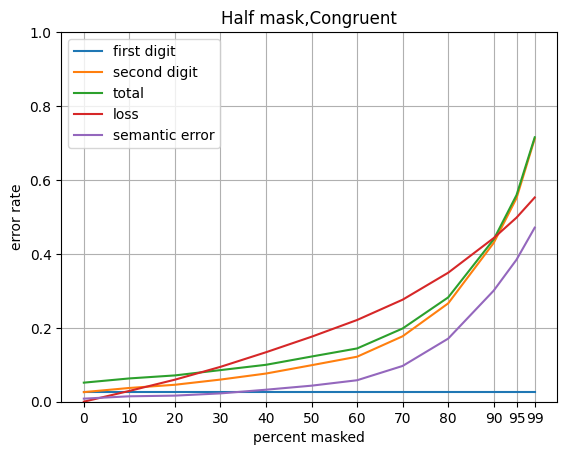

In [ ]:
plot_error(error1tt, error2tt, errors_totaltt, semantic_errortt, evalstt, Titlett)

In [ ]:
error1ft, error2ft, errors_totalft, semantic_errorft, evalsft , Titleft= masking_effect(model0,mod1_test_x,mod1_test_y,mod1_y_test,Congruency=False, Half_mask=True)

  0%|          | 0/12 [00:00<?, ?it/s]

52/52 [==============================] - 34s 657ms/step - loss: 1.2726e-04


  8%|▊         | 1/12 [01:18<14:18, 78.07s/it]

52/52 [==============================] - 36s 685ms/step - loss: 0.0314


 17%|█▋        | 2/12 [02:37<13:09, 78.96s/it]

52/52 [==============================] - 35s 679ms/step - loss: 0.0669


 25%|██▌       | 3/12 [03:55<11:47, 78.66s/it]

52/52 [==============================] - 36s 684ms/step - loss: 0.1055


 33%|███▎      | 4/12 [05:15<10:32, 79.01s/it]

52/52 [==============================] - 36s 694ms/step - loss: 0.1540


 42%|████▏     | 5/12 [06:35<09:15, 79.36s/it]

52/52 [==============================] - 35s 679ms/step - loss: 0.2081


 50%|█████     | 6/12 [07:54<07:55, 79.29s/it]

52/52 [==============================] - 36s 684ms/step - loss: 0.2733


 58%|█████▊    | 7/12 [09:13<06:35, 79.20s/it]

52/52 [==============================] - 35s 681ms/step - loss: 0.3548


 67%|██████▋   | 8/12 [10:32<05:16, 79.20s/it]

52/52 [==============================] - 36s 684ms/step - loss: 0.4513


 75%|███████▌  | 9/12 [11:52<03:57, 79.27s/it]

52/52 [==============================] - 35s 664ms/step - loss: 0.5636


 83%|████████▎ | 10/12 [13:10<02:38, 79.05s/it]

52/52 [==============================] - 35s 681ms/step - loss: 0.6131


 92%|█████████▏| 11/12 [14:31<01:19, 79.46s/it]

52/52 [==============================] - 35s 679ms/step - loss: 0.6432


100%|██████████| 12/12 [15:50<00:00, 79.20s/it]


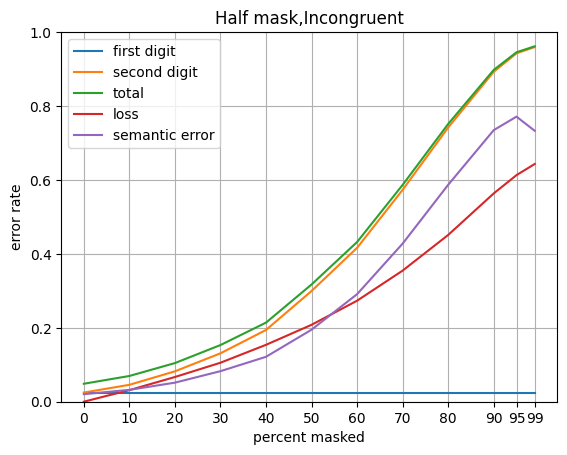

In [ ]:
plot_error(error1ft, error2ft, errors_totalft, semantic_errorft, evalsft, Titleft)

In [ ]:
mask_levels=[0, 10,20,30,40,50,60,70,80,90,95,99]
plt.plot(mask_levels,error1if, label='first digit',)
plt.plot(mask_levels,error2if, label='second digit')
plt.plot(mask_levels,errors_totalif, label='total')
plt.plot(mask_levels,evals, label='loss')
plt.plot(mask_levels,semantic_errorif, label='semantic error')
plt.xlabel('percent masked')
plt.ylabel('error rate')
plt.title(Titleif+' heldout')
plt.xticks(mask_levels,mask_levels)
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

In [ ]:
error1ch, error2ch, errors_totalch, semantic_errorch, evalsch , Titlech= masking_effect(model0,mod2_test_x,mod2_test_y,mod2_y_test,Congruency=True, Half_mask=True)

  0%|          | 0/12 [00:00<?, ?it/s]

3/3 [==============================] - 2s 457ms/step - loss: 1.1445e-05


  8%|▊         | 1/12 [00:04<00:44,  4.09s/it]

3/3 [==============================] - 2s 450ms/step - loss: 0.0333


 17%|█▋        | 2/12 [00:08<00:40,  4.03s/it]

3/3 [==============================] - 2s 461ms/step - loss: 0.0655


 25%|██▌       | 3/12 [00:12<00:36,  4.04s/it]

3/3 [==============================] - 2s 445ms/step - loss: 0.1081


 33%|███▎      | 4/12 [00:16<00:32,  4.04s/it]

3/3 [==============================] - 2s 442ms/step - loss: 0.1500


 42%|████▏     | 5/12 [00:20<00:28,  4.00s/it]

3/3 [==============================] - 2s 442ms/step - loss: 0.2039


 50%|█████     | 6/12 [00:24<00:23,  3.98s/it]

3/3 [==============================] - 2s 447ms/step - loss: 0.2605


 58%|█████▊    | 7/12 [00:28<00:19,  3.99s/it]

3/3 [==============================] - 2s 443ms/step - loss: 0.3419


 67%|██████▋   | 8/12 [00:31<00:15,  3.96s/it]

3/3 [==============================] - 2s 445ms/step - loss: 0.4133


 75%|███████▌  | 9/12 [00:35<00:11,  3.95s/it]

3/3 [==============================] - 2s 454ms/step - loss: 0.5440


 83%|████████▎ | 10/12 [00:39<00:07,  3.96s/it]

3/3 [==============================] - 2s 447ms/step - loss: 0.6209


 92%|█████████▏| 11/12 [00:43<00:03,  3.96s/it]

3/3 [==============================] - 2s 445ms/step - loss: 0.6586


100%|██████████| 12/12 [00:47<00:00,  3.98s/it]


In [ ]:
plot_error(error1ch, error2ch, errors_totalch, semantic_errorch, evalsch, Titlech)

In [ ]:
print(semantic_errorftt)

In [ ]:
error1ftt, error2ftt, errors_totalftt, semantic_errorftt, evalsftt , Titleftt= masking_effect(model0,mod2_test_x,mod2_test_y,mod2_y_test,Congruency=False, Half_mask=True,held_out=True)

  0%|          | 0/12 [00:00<?, ?it/s]

3/3 [==============================] - 2s 436ms/step - loss: 1.1445e-05


  8%|▊         | 1/12 [00:03<00:42,  3.85s/it]

3/3 [==============================] - 2s 441ms/step - loss: 0.0329


 17%|█▋        | 2/12 [00:07<00:38,  3.89s/it]

3/3 [==============================] - 2s 429ms/step - loss: 0.0670


 25%|██▌       | 3/12 [00:11<00:34,  3.88s/it]

3/3 [==============================] - 2s 429ms/step - loss: 0.1061


 33%|███▎      | 4/12 [00:15<00:30,  3.85s/it]

3/3 [==============================] - 2s 436ms/step - loss: 0.1483


 42%|████▏     | 5/12 [00:19<00:26,  3.85s/it]

3/3 [==============================] - 2s 427ms/step - loss: 0.2065


 50%|█████     | 6/12 [00:23<00:23,  3.88s/it]

3/3 [==============================] - 2s 432ms/step - loss: 0.2574


 58%|█████▊    | 7/12 [00:27<00:19,  3.86s/it]

3/3 [==============================] - 2s 431ms/step - loss: 0.3363


 67%|██████▋   | 8/12 [00:30<00:15,  3.85s/it]

3/3 [==============================] - 2s 441ms/step - loss: 0.4286


 75%|███████▌  | 9/12 [00:34<00:11,  3.87s/it]

3/3 [==============================] - 2s 429ms/step - loss: 0.5503


 83%|████████▎ | 10/12 [00:38<00:07,  3.87s/it]

3/3 [==============================] - 2s 433ms/step - loss: 0.6158


 92%|█████████▏| 11/12 [00:42<00:03,  3.87s/it]

3/3 [==============================] - 2s 441ms/step - loss: 0.6616


100%|██████████| 12/12 [00:46<00:00,  3.86s/it]


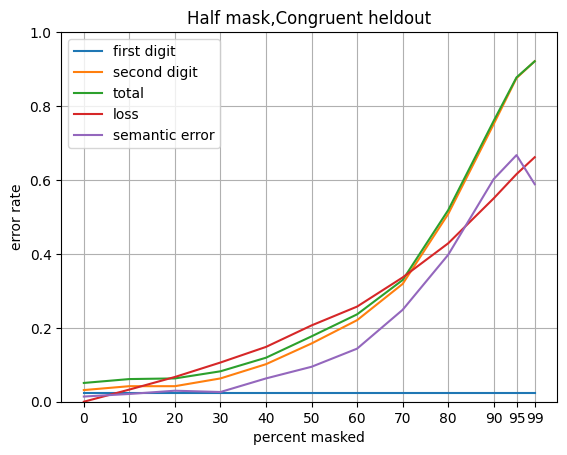

In [ ]:
plot_error(error1ftt, error2ftt, errors_totalftt, semantic_errorftt, evalsftt, Titleftt)

In [ ]:
error1fft, error2fft, errors_totalfft, semantic_errorfft, evalsfft , Titlefft= masking_effect(model0,mod2_test_x,mod2_test_y,mod2_y_test,Congruency=False, Half_mask=False,held_out=True)

In [ ]:
plot_error(error1fft, error2fft, errors_totalfft, semantic_errorfft, evalsfft, Titlefft)

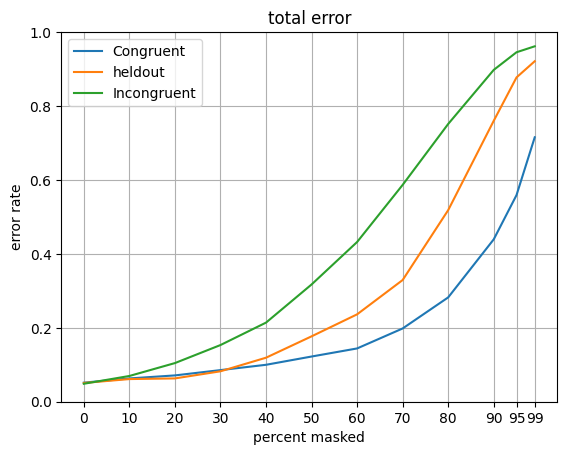

In [ ]:
#Plot comparison:
mask_levels=[0, 10,20,30,40,50,60,70,80,90,95,99]
plt.plot(mask_levels,errors_totaltt, label='Congruent')
plt.plot(mask_levels,errors_totalftt, label='heldout')
plt.plot(mask_levels,errors_totalft, label='Incongruent')

#plt.plot(mask_levels,evals, label='loss')
#plt.plot(mask_levels,semantic_errorcf, label='semantic error')
plt.xlabel('percent masked')
plt.ylabel('error rate')
plt.title("total error")
plt.xticks(mask_levels,mask_levels)
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

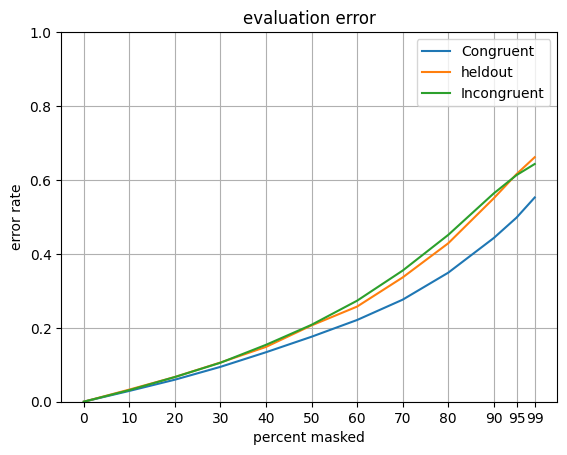

In [ ]:
#Plot comparison:
mask_levels=[0, 10,20,30,40,50,60,70,80,90,95,99]
plt.plot(mask_levels,evalstt, label='Congruent')
plt.plot(mask_levels,evalsftt, label='heldout')
plt.plot(mask_levels,evalsft, label='Incongruent')

#plt.plot(mask_levels,evals, label='loss')
#plt.plot(mask_levels,semantic_errorcf, label='semantic error')
plt.xlabel('percent masked')
plt.ylabel('error rate')
plt.title("evaluation error")
plt.xticks(mask_levels,mask_levels)
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

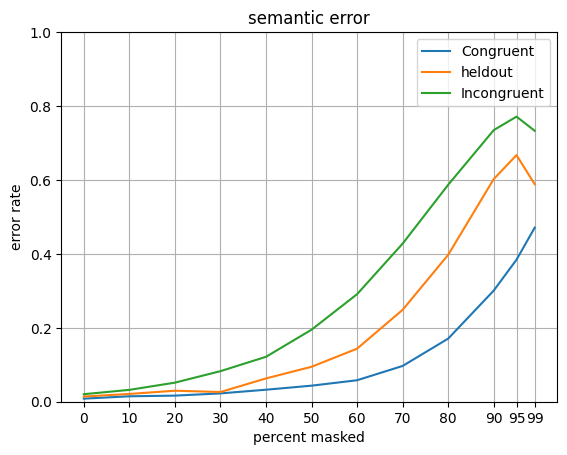

In [ ]:
mask_levels=[0, 10,20,30,40,50,60,70,80,90,95,99]
plt.plot(mask_levels, semantic_errortt, label='Congruent')
plt.plot(mask_levels, semantic_errorftt, label='heldout')
plt.plot(mask_levels, semantic_errorft, label='Incongruent')

#plt.plot(mask_levels,evals, label='loss')
#plt.plot(mask_levels,semantic_errorcf, label='semantic error')
plt.xlabel('percent masked')
plt.ylabel('error rate')
plt.title("semantic error")
plt.xticks(mask_levels,mask_levels)
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

##Selective attention

here I have played with confidence matrix to understand its properties

In [ ]:
n_rec = 800
mod0_masked_test_x = half_mask(mod1_test_x[:n_rec],0,0)
# see https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.MaskedLMOutput
reconstructions = model0.predict({'inputs_embeds': mod0_masked_test_x[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)

logits = reconstructions.logits
#logits= tf.nn.softmax(logits, axis=-1).numpy()
most_probable = logits.argmax(axis=-1)

confidence=logits.max(axis=-1)

4/4 [==============================] - 4s 505ms/step


In [ ]:
a=np.zeros((n_rec,98),dtype=int)
a[mask_pattern]=1
a[~true_recons]=2


NameError: name 'mask_pattern' is not defined

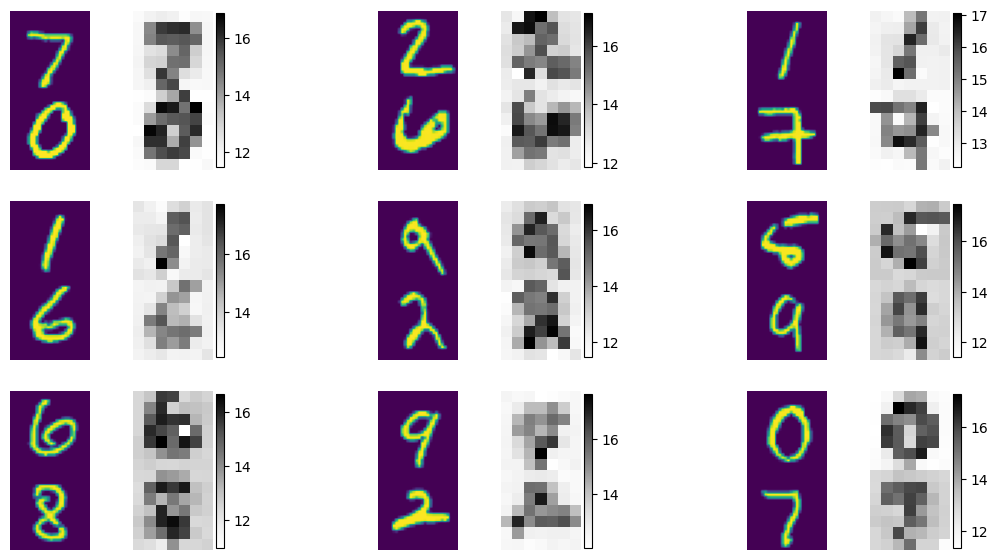

In [ ]:
#plot ten images of the largest _logit values reshaped into (14,7) with a shared colorbar range

plt.figure(figsize=(14,7))
for i in range(n_rec):
    plt.subplot(3,n_rec,3*i+1)
    plt.imshow(mod1_x_test[i].reshape(56,28))
    plt.axis('off')
    plt.subplot(3,n_rec,3*i+2)
    plt.imshow(confidence[i].reshape(14,7),cmap='Greys')
    plt.axis('off')
    plt.colorbar(fraction=0.075, pad=0.04)
    #plt.subplot(3,n_rec,3*i+3)
    #plt.imshow(a[i].reshape(14,7),cmap='RdGy_r')

    plt.axis('off')

plt.show()


In [ ]:
n_rec = 100
mod0_masked_test_x = half_mask(mod0_test_x[:n_rec],0,0.8)
# see https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.MaskedLMOutput
reconstructions = model0.predict({'inputs_embeds': mod0_masked_test_x[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)

logits = reconstructions.logits
#logits= tf.nn.softmax(logits, axis=-1).numpy()

most_probable = logits.argmax(axis=-1)

confidence=logits.max(axis=-1)

1/1 [==============================] - 0s 39ms/step


In [ ]:
correct_value= mod0_test_y[:n_rec]
correcrect_confidence= np.array([logits[i, j, correct_value[i, j]] for i in range(n_rec) for j in range(98)]).reshape((n_rec, 98))



In [ ]:
mask_pattern=mod0_masked_test_x[:n_rec,:,0]==0
true_recons= logits.argmax(axis=-1)==mod0_test_y[:n_rec]

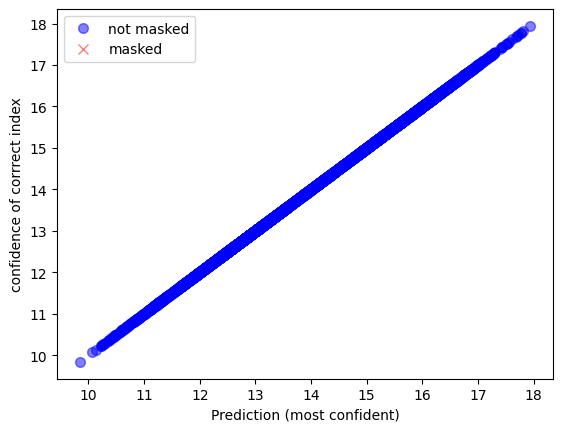

In [ ]:
#plot an scatter plot of flattened confidence vs corrected confidence
plt.plot(confidence[~mask_pattern], correcrect_confidence[~mask_pattern], 'o', markersize= 7, color = 'b', alpha=0.5)
plt.plot(confidence[mask_pattern], correcrect_confidence[mask_pattern], 'x', markersize= 7, color = 'r',  alpha=0.5)

plt.xlabel('Prediction (most confident)')
plt.ylabel('confidence of corrrect index')
plt.legend(['not masked','masked'])
#plt.plot(confidence[true_recons], correcrect_confidence[true_recons], 'x', markersize= 3, color = 'r')
#plt.plot(confidence[~true_recons], correcrect_confidence[~true_recons], 'x', markersize= 3, color = 'b')

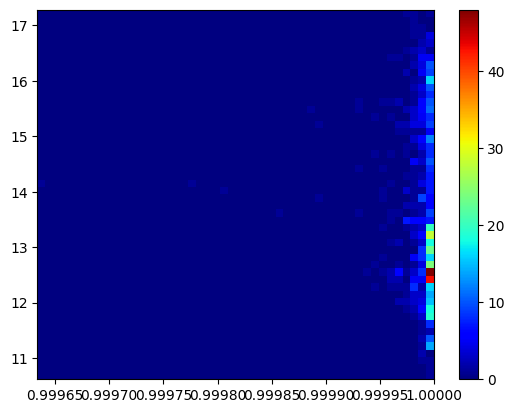

In [ ]:
plt.hist2d(confidence[~mask_pattern], correcrect_confidence[~mask_pattern],(50,50), cmap=plt.cm.jet)
plt.colorbar()

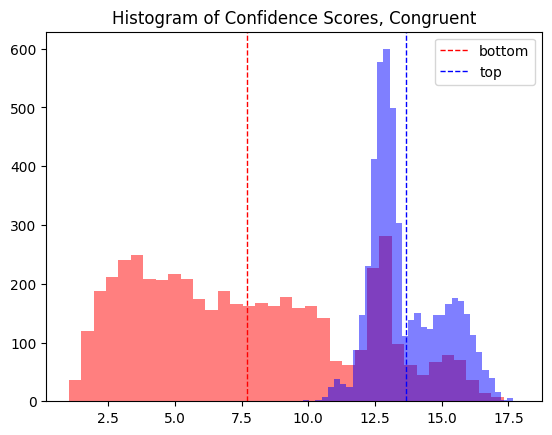

In [ ]:
plt.hist(confidence[:,49:].flatten(), 35, alpha=0.5, color='r')
plt.axvline(confidence[:,49:].flatten().mean(), color='r', linestyle='dashed', linewidth=1)
plt.hist(confidence[:,0:49].flatten(), 35, alpha=0.5, color='b')
plt.axvline(confidence[:,0:49].flatten().mean(), color='b', linestyle='dashed', linewidth=1)
plt.title('Histogram of Confidence Scores, Congruent')
plt.legend(['bottom', 'top'])

In [ ]:
confidence[~mask_pattern].mean()

13.6425085

incongruent data?

In [ ]:
n_rec = 100
mod1_masked_test_x = half_mask(mod1_test_x[:n_rec],0,0.8)
# see https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.MaskedLMOutput
reconstructions1 = model0.predict({'inputs_embeds': mod1_masked_test_x[:n_rec].astype('float32'), 'labels': mod1_test_y[:n_rec].astype('float32')}, batch_size=256)

logits1 = reconstructions1.logits
#logits1= tf.nn.softmax(logits, axis=-1).numpy()

most_probable1 = logits1.argmax(axis=-1)

confidence1=logits1.max(axis=-1)

1/1 [==============================] - 0s 42ms/step


In [ ]:
correct_value1= mod1_test_y[:n_rec]
correcrect_confidence1= np.array([logits1[i, j, correct_value1[i, j]] for i in range(n_rec) for j in range(98)]).reshape((n_rec, 98))


In [ ]:
mask_pattern1=mod1_masked_test_x[:n_rec,:,0]==0
true_recons1= logits1.argmax(axis=-1)==mod1_test_y[:n_rec]

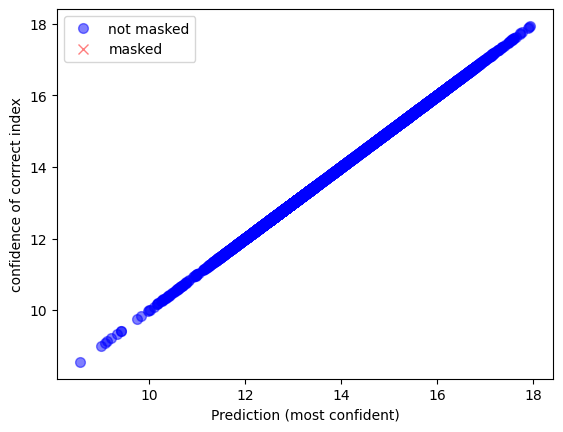

In [ ]:
#plot an scatter plot of flattened confidence vs corrected confidence
plt.plot(confidence1[~mask_pattern1], correcrect_confidence1[~mask_pattern1], 'o', markersize= 7, color = 'b', alpha=0.5)
plt.plot(confidence1[mask_pattern1], correcrect_confidence1[mask_pattern1], 'x', markersize= 7, color = 'r',  alpha=0.5)

plt.xlabel('Prediction (most confident)')
plt.ylabel('confidence of corrrect index')
plt.legend(['not masked','masked'])
#plt.plot(confidence1[true_recons1], correcrect_confidence1[true_recons1], 'x', markersize= 3, color = 'r')
#plt.plot(confidence1[~true_recons1], correcrect_confidence1[~true_recons1], 'x', markersize= 3, color = 'b')


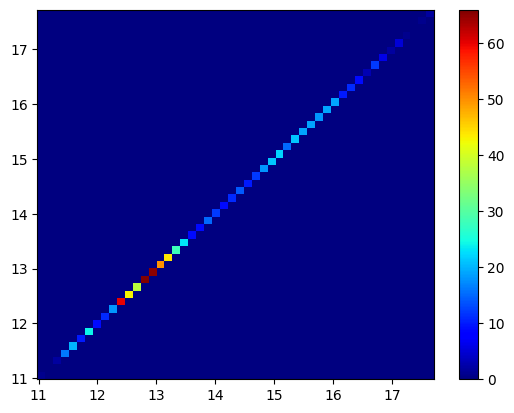

In [ ]:
plt.hist2d(confidence1[~mask_pattern1], correcrect_confidence1[~mask_pattern1],(50,50), cmap=plt.cm.jet)
plt.colorbar()

Text(0.5, 1.0, 'Histogram of Confidence Scores, Inongruent')

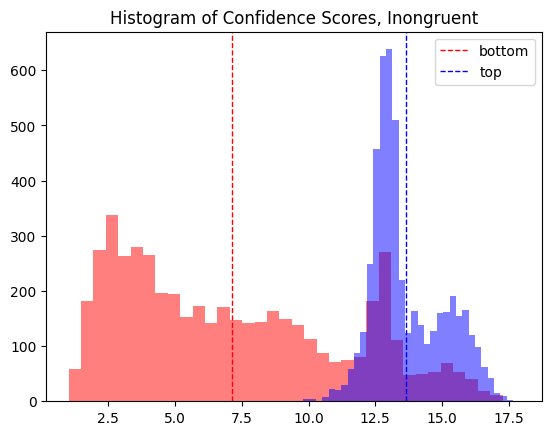

In [ ]:
plt.hist(confidence1[:,49:].flatten(), 35, alpha=0.5, color='r')
plt.axvline(confidence1[:,49:].flatten().mean(), color='r', linestyle='dashed', linewidth=1)
plt.hist(confidence1[:,0:49].flatten(), 35, alpha=0.5, color='b')
plt.axvline(confidence1[:,0:49].flatten().mean(), color='b', linestyle='dashed', linewidth=1)
plt.legend(['bottom', 'top'])
plt.title('Histogram of Confidence Scores, Inongruent')

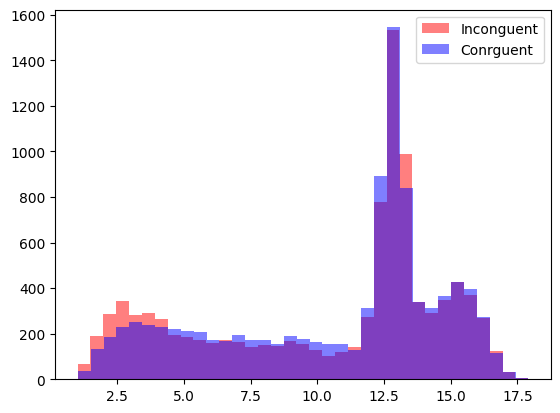

In [ ]:
plt.hist(confidence1.flatten(), 35, alpha=0.5, color='r')
plt.hist(confidence.flatten(), 35, alpha=0.5, color='b')
plt.legend(['Inconguent', 'Conrguent'])

In [ ]:
digitup=np.zeros((14,7),dtype=bool)
digitup[1:6,1:6]=1
digitup=digitup.flatten()
digitdown=np.zeros((14,7),dtype=bool)
digitdown[8:13,1:6]=1
digitdown=digitdown.flatten()

digit=(digitup+digitdown).flatten()



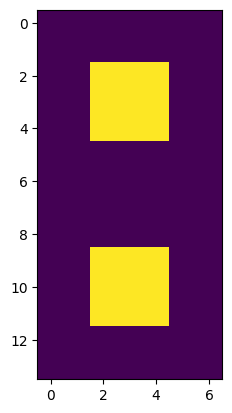

In [ ]:
# digitup=np.zeros((14,7),dtype=bool)
# digitup[2:5,2:5]=1
# digitup=digitup.flatten()
# digitdown=np.zeros((14,7),dtype=bool)
# digitdown[9:12,2:5]=1
# digitdown=digitdown.flatten()

# digit=(digitup+digitdown).flatten()
# plt.imshow(digit.reshape((14,7)))


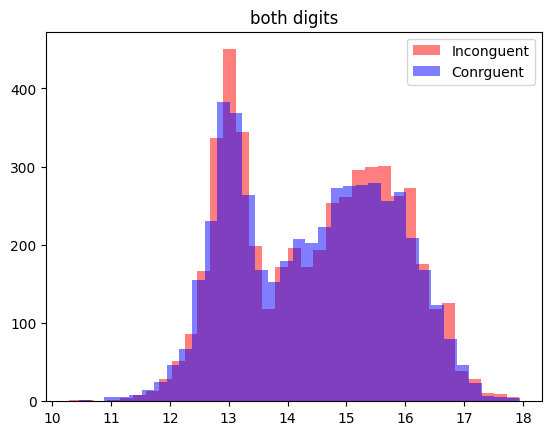

In [ ]:
plt.hist(confidence1[:,digit].flatten(), 35, alpha=0.5, color='r')
plt.hist(confidence[:,digit].flatten(), 35, alpha=0.5, color='b')
plt.title('both digits')
plt.legend(['Inconguent', 'Conrguent'])

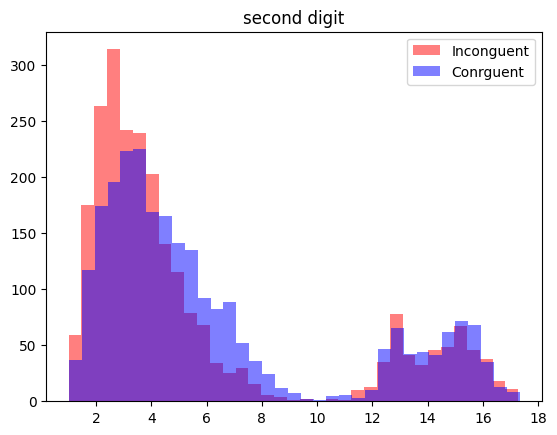

In [ ]:
plt.hist(confidence1[:,digitdown].flatten(), 35, alpha=0.5, color='r')
plt.hist(confidence[:,digitdown].flatten(), 35, alpha=0.5, color='b')
plt.title('second digit')
plt.legend(['Inconguent', 'Conrguent'])

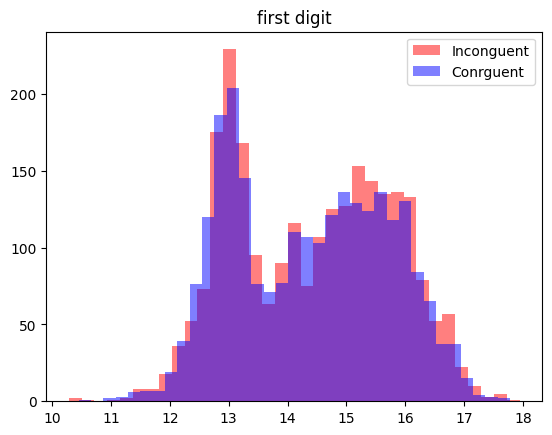

In [ ]:
plt.hist(confidence1[:,digitup].flatten(), 35, alpha=0.5, color='r')
plt.hist(confidence[:,digitup].flatten(), 35, alpha=0.5, color='b')
plt.title('first digit')
plt.legend(['Inconguent', 'Conrguent'])

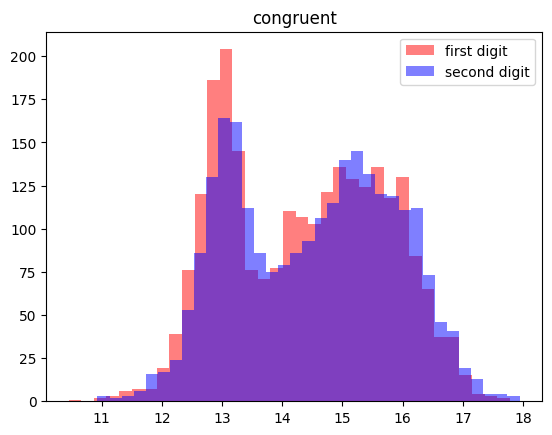

In [ ]:
plt.hist(confidence[:,digitup].flatten(), 35, alpha=0.5, color='r')
plt.hist(confidence[:,digitdown].flatten(), 35, alpha=0.5, color='b')
plt.title('congruent')
plt.legend(['first digit', 'second digit'])

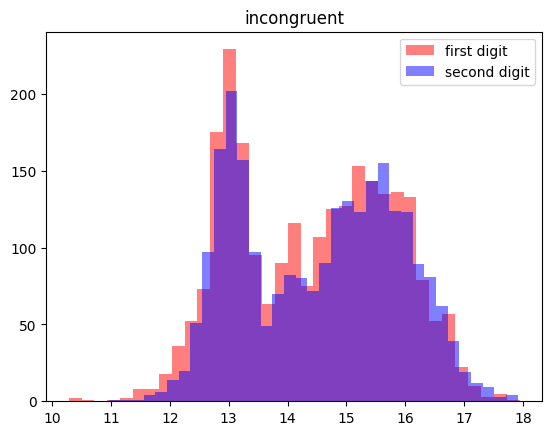

In [ ]:
plt.hist(confidence1[:,digitup].flatten(), 35, alpha=0.5, color='r')
plt.hist(confidence1[:,digitdown].flatten(), 35, alpha=0.5, color='b')
plt.title('incongruent')
plt.legend(['first digit', 'second digit'])

<ipython-input-208-0ad335c46f93>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('hot', 15)


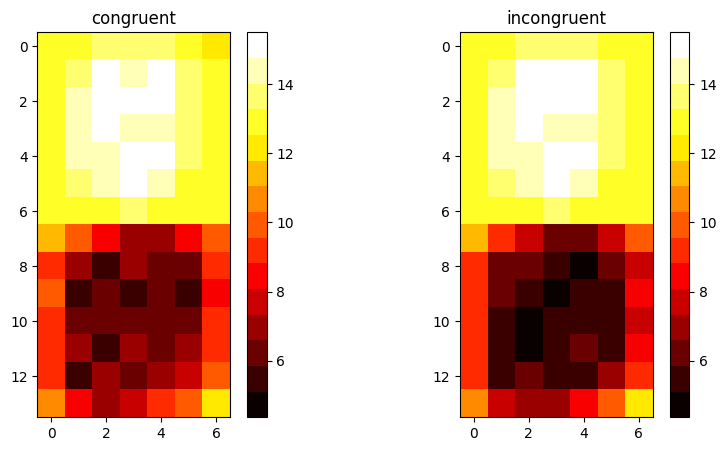

In [ ]:
plt.figure(figsize=(10,5))
cmap=plt.cm.get_cmap('hot', 15)
#cmap='gist_rainbow'
v_min1= confidence1.mean(axis=0).min()
v_max1= confidence1.mean(axis=0).max()
v_min0= confidence.mean(axis=0).min()
v_max0= confidence.mean(axis=0).max()

plt.subplot(1,2,1)
plt.imshow(confidence.mean(axis=0).reshape((14,7)),cmap=cmap, vmin=min(v_min0,v_min1),vmax=max(v_max1,v_max0))
plt.title('congruent')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(confidence1.mean(axis=0).reshape((14,7)),cmap=cmap,vmin=min(v_min0,v_min1),vmax=max(v_max1,v_max0))
plt.title('incongruent')
plt.colorbar()

In [ ]:
print(confidence.mean(axis=0).min(), confidence.mean(axis=0).max())

12.395419 15.373724


In [ ]:
print(confidence1.mean(axis=0).min(), confidence1.mean(axis=0).max())

12.516662 15.373724


In [ ]:
sorted_conf= np.sort(confidence, axis=1)
conf_mean=(np.sort(confidence, axis=1)).mean(axis=0)
conf1_mean=(np.sort(confidence1, axis=1)).mean(axis=0)
conf_std=(np.sort(confidence, axis=1)).std(axis=0)
conf1_std=(np.sort(confidence1, axis=1)).std(axis=0)

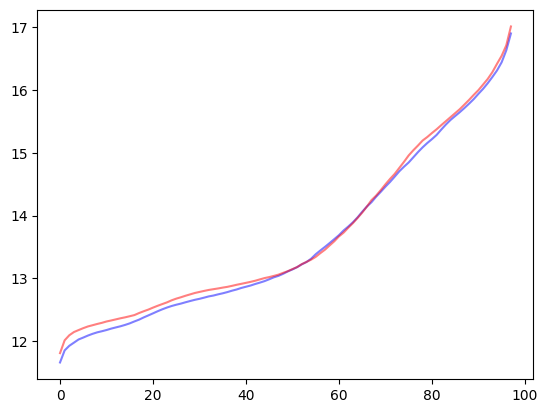

In [ ]:
plt.plot(conf_mean, '-', markersize= 7, color = 'b', alpha=0.5)
plt.plot(conf1_mean, '-', markersize= 7, color = 'r', alpha=0.5)

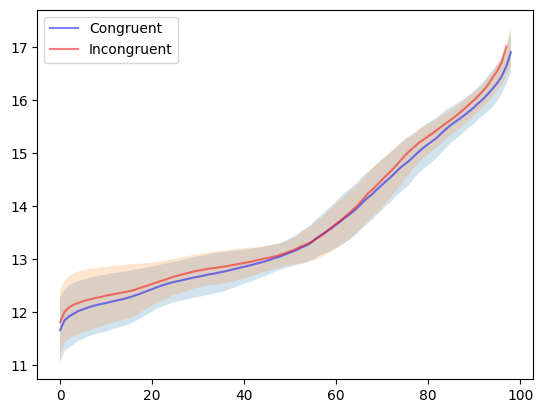

In [ ]:
x=np.linspace(0,98,98)
fig, ax = plt.subplots()
ax.plot(x,conf_mean, '-', markersize= 7, color = 'b', alpha=0.5)
ax.plot(conf1_mean, '-', markersize= 7, color = 'r', alpha=0.5)

ax.fill_between(x,conf_mean - conf_std, conf_mean + conf_std, alpha=0.2)
ax.fill_between(x,conf1_mean - conf1_std, conf1_mean + conf1_std, alpha=0.2)
plt.legend(['Congruent', 'Incongruent'])
#ax.plot(x, y, 'o', color='tab:brown')

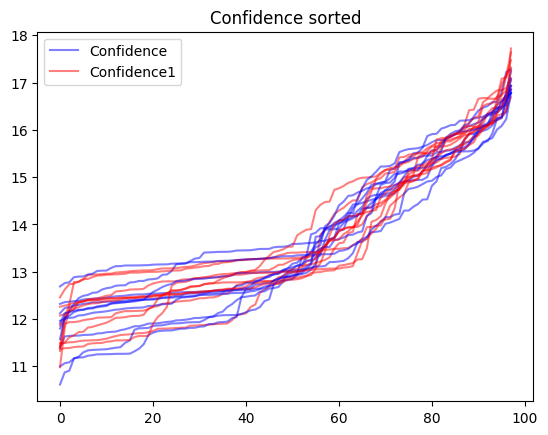

In [ ]:
for i in range(10):
  plt.plot(np.sort(confidence[i]), '-', markersize= 3 , color = 'b', alpha=0.5)
  plt.plot(np.sort(confidence1[i]), '-', markersize= 3 , color = 'r', alpha=0.5)
plt.title('Confidence sorted')
plt.legend(['Confidence', 'Confidence1'])

##Test selective attention

I always first explore the thing I want to model and then write a big function.

In [ ]:
n_rec = 100
mod0_masked_test_x = half_mask(mod0_test_x[:n_rec],0,0)
# see https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.MaskedLMOutput
reconstructions = model0.predict({'inputs_embeds': mod0_masked_test_x[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)

logits = reconstructions.logits
#logits= tf.nn.softmax(logits, axis=-1).numpy()

most_probable = logits.argmax(axis=-1)

confidence=logits.max(axis=-1)

1/1 [==============================] - 0s 42ms/step


In [ ]:
confidence=logits.max(axis=-1)

In [ ]:
mask=confidence<15


In [ ]:
print('mask ratio=',round((np.sum(mask)/(n_rec*98)),3))

mask ratio= 0.784


In [ ]:
for conf in conf_range:
  mask=confidence<conf
  print('conf=',round(conf,2),'mask ratio=',round((np.sum(mask)/(n_rec*98)),2))

conf= 10.0 mask ratio= 0.0
conf= 10.26 mask ratio= 0.0
conf= 10.52 mask ratio= 0.0
conf= 10.77 mask ratio= 0.01
conf= 11.03 mask ratio= 0.01
conf= 11.29 mask ratio= 0.02
conf= 11.55 mask ratio= 0.03
conf= 11.81 mask ratio= 0.06
conf= 12.06 mask ratio= 0.1
conf= 12.32 mask ratio= 0.15
conf= 12.58 mask ratio= 0.24
conf= 12.84 mask ratio= 0.35
conf= 13.1 mask ratio= 0.48
conf= 13.35 mask ratio= 0.57
conf= 13.61 mask ratio= 0.62
conf= 13.87 mask ratio= 0.64
conf= 14.13 mask ratio= 0.68
conf= 14.39 mask ratio= 0.71
conf= 14.65 mask ratio= 0.74
conf= 14.9 mask ratio= 0.77
conf= 15.16 mask ratio= 0.81
conf= 15.42 mask ratio= 0.84
conf= 15.68 mask ratio= 0.88
conf= 15.94 mask ratio= 0.92
conf= 16.19 mask ratio= 0.95
conf= 16.45 mask ratio= 0.97
conf= 16.71 mask ratio= 0.98
conf= 16.97 mask ratio= 0.99
conf= 17.23 mask ratio= 1.0
conf= 17.48 mask ratio= 1.0
conf= 17.74 mask ratio= 1.0
conf= 18.0 mask ratio= 1.0


In [ ]:
conf=[11.03,11.81,12.06,12.32,12.58,12.84,13.1,]

In [ ]:
#masking procedure
confidence=logits.max(axis=-1)
mask_level= 31
#partitioned = np.partition(confidence,48,axis=-1)
sorted= np.sort(confidence,axis=-1)
#argsort=np.argsort(confidence,axis=-1)

In [ ]:
thresh=sorted[:,mask_level]
#mask=
#confidence[mask]=0
#super_threshold_indices = a > thresh
#a[super_threshold_indices] = 0

#mask[i,:]=confidence[i,:]<thresh[i]

In [ ]:
mask=confidence<thresh[:,np.newaxis]
confidence[mask]=0


In [ ]:
data=np.copy(mod0_masked_test_x)
data[mask]=0


In [ ]:
reconstructions = model0.predict({'inputs_embeds': data.astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)

logits = reconstructions.logits
#logits= tf.nn.softmax(logits, axis=-1).numpy()

most_probable = logits.argmax(axis=-1)

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 18ms/step


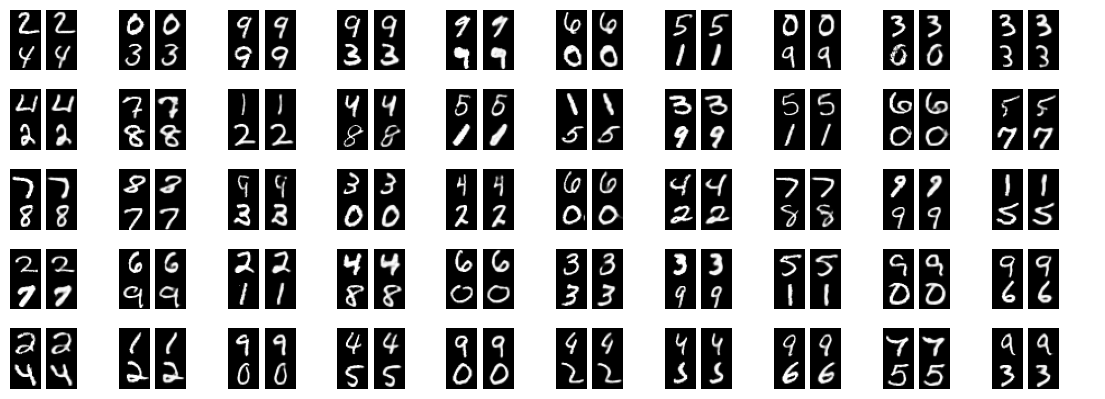

In [ ]:
dec1, dec2 = decode(most_probable, codes_sampler)
plot_decode(dec1, dec2,mod0_x_test[:100,:,:,0], 100,5,10)

In [ ]:
print('mask ratio=',round((np.sum(mask)/(n_rec*98)),3))

mask ratio= 0.316


In [ ]:

mask_levels=np.array([0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99])
mask_levels=np.round((mask_levels*98),2)
print(mask_levels)
n= mask_levels.size

[ 0.    9.8  19.6  29.4  39.2  49.   58.8  68.6  78.4  88.2  93.1  97.02]


In [ ]:
#masking according to confidence matrix values (selective attention)

n_rec = 500
mask_levels=np.array([0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99])
mask_levels=np.round(mask_levels*98).astype('int')

#n = mask_levels.size
n=12
error1 = np.zeros(n)
error2 = np.zeros(n)
errors_total = np.zeros(n)
evals=np.zeros(n)
semantic_error=np.zeros(n)
Congruency="congruent"
held_out= False
y_test=mod0_y_test[:n_rec]


mod0_masked_test_x = half_mask(mod0_test_x[:n_rec],0,0)
#masked_test_x = mod0_test_x.reshape(( masked_test_x.shape[0], n_tokens))
reconstructions = model0.predict({'inputs_embeds': mod0_masked_test_x.astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)
logits = reconstructions.logits
most_probable = logits.argmax(axis=-1)
confidence=logits.max(axis=-1)

sorted_conf= np.sort(confidence,axis=-1)

for i in tqdm(range(n)):
  thresh=sorted_conf[:,mask_levels[i]]
  mask=confidence<thresh[:,np.newaxis]
  conf_temp=np.copy(confidence)
  data=np.copy(mod0_masked_test_x)
  data[mask]=0
  reconstructions = model0.predict({'inputs_embeds': data.astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)
  logits = reconstructions.logits
  most_probable = logits.argmax(axis=-1)
  decoded1, decoded2 = decode(most_probable, codes_sampler)
  class1=classifier.predict(decoded1).argmax(axis=-1)
  class2=classifier.predict(decoded2).argmax(axis=-1)
  error1[i]= (class1 != y_test//10).mean()
  error2[i]= (class2 != y_test%10).mean()
  errors_total[i] = (class1*10 + class2 != y_test).mean()
  if Congruency:
    congttl='Congruent'
    semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0) & (class1*10 + class2 != 0)).mean()
  elif Congruency or not held_out:
    semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0)& (class1*10 + class2 != 0)).mean()
    congttl='Incongruent'
  elif held_out:
    semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0)& (class1*10 + class2 != 0)).mean()
    congttl='Congruent heldout'

  #evals[i]=model0.evaluate({'inputs_embeds': masked_test_x.astype('float32'), 'labels': test_y.astype('float32')}, batch_size=256)
  Title=congttl

2/2 [==============================] - 1s 634ms/step


  0%|          | 0/12 [00:00<?, ?it/s]

16/16 [==============================] - 0s 5ms/step


  8%|▊         | 1/12 [00:01<00:21,  1.93s/it]

16/16 [==============================] - 0s 5ms/step


 17%|█▋        | 2/12 [00:03<00:19,  1.92s/it]

16/16 [==============================] - 0s 6ms/step


 25%|██▌       | 3/12 [00:05<00:17,  1.93s/it]

16/16 [==============================] - 0s 6ms/step


 33%|███▎      | 4/12 [00:07<00:15,  1.94s/it]

16/16 [==============================] - 0s 6ms/step


 42%|████▏     | 5/12 [00:09<00:13,  1.95s/it]

16/16 [==============================] - 0s 6ms/step


 50%|█████     | 6/12 [00:11<00:11,  1.96s/it]

16/16 [==============================] - 0s 6ms/step


 58%|█████▊    | 7/12 [00:13<00:09,  1.96s/it]

16/16 [==============================] - 0s 5ms/step


 67%|██████▋   | 8/12 [00:15<00:07,  1.95s/it]

16/16 [==============================] - 0s 6ms/step


 75%|███████▌  | 9/12 [00:17<00:05,  1.95s/it]

16/16 [==============================] - 0s 5ms/step


 83%|████████▎ | 10/12 [00:19<00:03,  1.95s/it]

16/16 [==============================] - 0s 6ms/step


 92%|█████████▏| 11/12 [00:21<00:01,  1.95s/it]

16/16 [==============================] - 0s 6ms/step


100%|██████████| 12/12 [00:23<00:00,  1.95s/it]


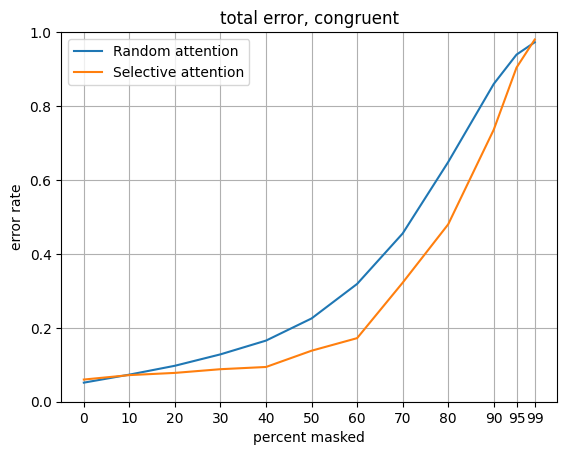

In [ ]:
#Plot comparison:
mask_levels=[0, 10,20,30,40,50,60,70,80,90,95,99]
plt.plot(mask_levels,errors_totaltf, label='Random attention')
#plt.plot(mask_levels,evalsftt, label='heldout')
plt.plot(mask_levels,errors_total, label='Selective attention')

#plt.plot(mask_levels,evals, label='loss')
#plt.plot(mask_levels,semantic_errorcf, label='semantic error')
plt.xlabel('percent masked')
plt.ylabel('error rate')
plt.title("total error, congruent")
plt.xticks(mask_levels,mask_levels)
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

In [ ]:
def plot_error(error1, error2, errors_total, semantic_error, Title):
  mask_levels=[0, 10,20,30,40,50,60,70,80,90,95,99]
  plt.plot(mask_levels,error1, label='first digit',)
  plt.plot(mask_levels,error2, label='second digit')
  plt.plot(mask_levels,errors_total, label='total')
  #plt.plot(mask_levels,evals, label='loss')
  plt.plot(mask_levels,semantic_error, label='semantic error')
  plt.xlabel('percent masked')
  plt.ylabel('error rate')
  plt.title(Title + ', Full mask, Selective Attention')
  plt.xticks(mask_levels,mask_levels)
  plt.ylim(0,1)
  plt.grid()
  plt.legend()
  plt.show()

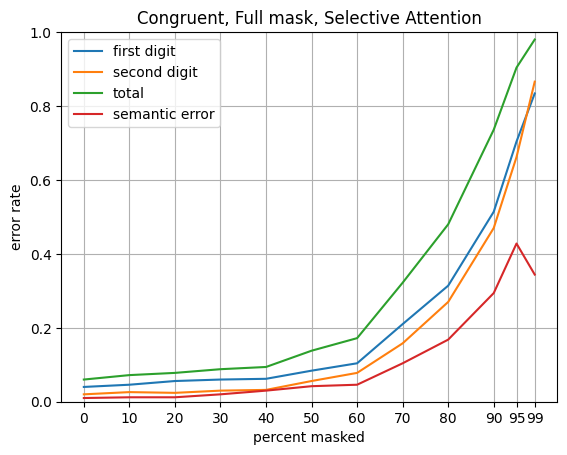

In [ ]:
plot_error(error1, error2, errors_total, semantic_error, Title)

In [ ]:
n_rec = 500
mask_levels=np.array([0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99])
mask_levels=np.round(mask_levels*98).astype('int')

#n = mask_levels.size
n=12
error1 = np.zeros(n)
error2 = np.zeros(n)
errors_total = np.zeros(n)
evals=np.zeros(n)
semantic_error=np.zeros(n)
Congruency=False
held_out= False
y_test=mod1_y_test[:n_rec]


mod1_masked_test_x = half_mask(mod1_test_x[:n_rec],0,0)
#masked_test_x = mod0_test_x.reshape(( masked_test_x.shape[0], n_tokens))
reconstructions = model0.predict({'inputs_embeds': mod1_masked_test_x.astype('float32'), 'labels': mod1_test_y[:n_rec].astype('float32')}, batch_size=256)
logits = reconstructions.logits
most_probable = logits.argmax(axis=-1)
confidence=logits.max(axis=-1)

sorted_conf= np.sort(confidence,axis=-1)

for i in tqdm(range(n)):
  thresh=sorted_conf[:,mask_levels[i]]
  mask=confidence<thresh[:,np.newaxis]
  conf_temp=np.copy(confidence)
  data=np.copy(mod1_masked_test_x)
  data[mask]=0
  reconstructions = model0.predict({'inputs_embeds': data.astype('float32'), 'labels': mod1_test_y[:n_rec].astype('float32')}, batch_size=256)
  logits = reconstructions.logits
  most_probable = logits.argmax(axis=-1)
  decoded1, decoded2 = decode(most_probable, codes_sampler)
  class1=classifier.predict(decoded1).argmax(axis=-1)
  class2=classifier.predict(decoded2).argmax(axis=-1)
  error1[i]= (class1 != y_test//10).mean()
  error2[i]= (class2 != y_test%10).mean()
  errors_total[i] = (class1*10 + class2 != y_test).mean()
  if Congruency:
    congttl='Congruent'
    semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0) & (class1*10 + class2 != 0)).mean()
  elif Congruency or not held_out:
    semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0)& (class1*10 + class2 != 0)).mean()
    congttl='Incongruent'
  elif held_out:
    semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0)& (class1*10 + class2 != 0)).mean()
    congttl='Congruent heldout'

  #evals[i]=model0.evaluate({'inputs_embeds': masked_test_x.astype('float32'), 'labels': test_y.astype('float32')}, batch_size=256)
  Title=congttl

2/2 [==============================] - 1s 632ms/step


  0%|          | 0/12 [00:00<?, ?it/s]

16/16 [==============================] - 0s 6ms/step


  8%|▊         | 1/12 [00:01<00:21,  1.93s/it]

16/16 [==============================] - 0s 6ms/step


 17%|█▋        | 2/12 [00:03<00:19,  1.93s/it]

16/16 [==============================] - 0s 6ms/step


 25%|██▌       | 3/12 [00:05<00:17,  1.93s/it]

16/16 [==============================] - 0s 6ms/step


 33%|███▎      | 4/12 [00:07<00:15,  1.95s/it]

16/16 [==============================] - 0s 6ms/step


 42%|████▏     | 5/12 [00:09<00:13,  1.96s/it]

16/16 [==============================] - 0s 6ms/step


 50%|█████     | 6/12 [00:11<00:11,  1.95s/it]

16/16 [==============================] - 0s 6ms/step


 58%|█████▊    | 7/12 [00:13<00:09,  1.94s/it]

16/16 [==============================] - 0s 5ms/step


 67%|██████▋   | 8/12 [00:15<00:07,  1.93s/it]

16/16 [==============================] - 0s 6ms/step


 75%|███████▌  | 9/12 [00:17<00:05,  1.93s/it]

16/16 [==============================] - 0s 6ms/step


 83%|████████▎ | 10/12 [00:19<00:03,  1.93s/it]

16/16 [==============================] - 0s 6ms/step


 92%|█████████▏| 11/12 [00:21<00:01,  1.94s/it]

16/16 [==============================] - 0s 6ms/step


100%|██████████| 12/12 [00:23<00:00,  1.94s/it]


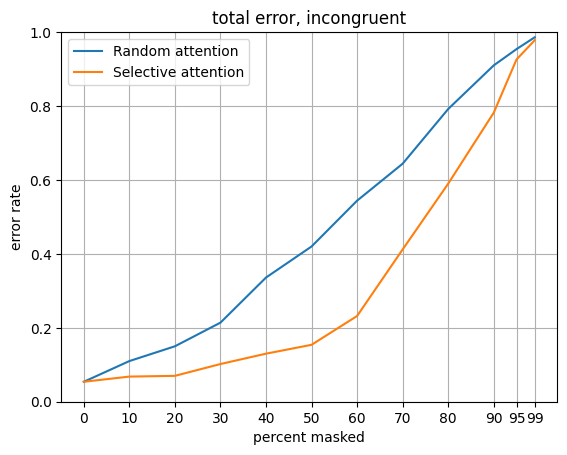

In [ ]:
#Plot comparison:
mask_levels=[0, 10,20,30,40,50,60,70,80,90,95,99]
plt.plot(mask_levels,errors_totalff, label='Random attention')
#plt.plot(mask_levels,evalsftt, label='heldout')
plt.plot(mask_levels,errors_total, label='Selective attention')

#plt.plot(mask_levels,evals, label='loss')
#plt.plot(mask_levels,semantic_errorcf, label='semantic error')
plt.xlabel('percent masked')
plt.ylabel('error rate')
plt.title("total error, incongruent")
plt.xticks(mask_levels,mask_levels)
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

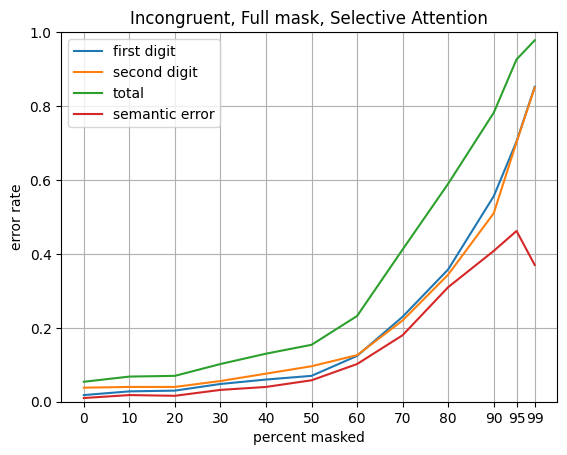

In [ ]:
plot_error(error1, error2, errors_total, semantic_error, Title)

## Additive attention


In [ ]:
n_rec = 9
mod0_masked_test_x = half_mask(mod0_test_x[:n_rec],1,1)
reconstructions = model0.predict({'inputs_embeds': mod0_masked_test_x[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)

logits = reconstructions.logits
#logits= tf.nn.softmax(logits, axis=-1).numpy()

confidence=logits.max(axis=-1)


most_probable1 = logits.argmax(axis=-1)

1/1 [==============================] - 2s 2s/step


In [ ]:
dec1, dec2 = decode(most_probable1, codes_sampler)
decoded=np.hstack((dec1, dec2))

NameError: name 'codes_sampler' is not defined

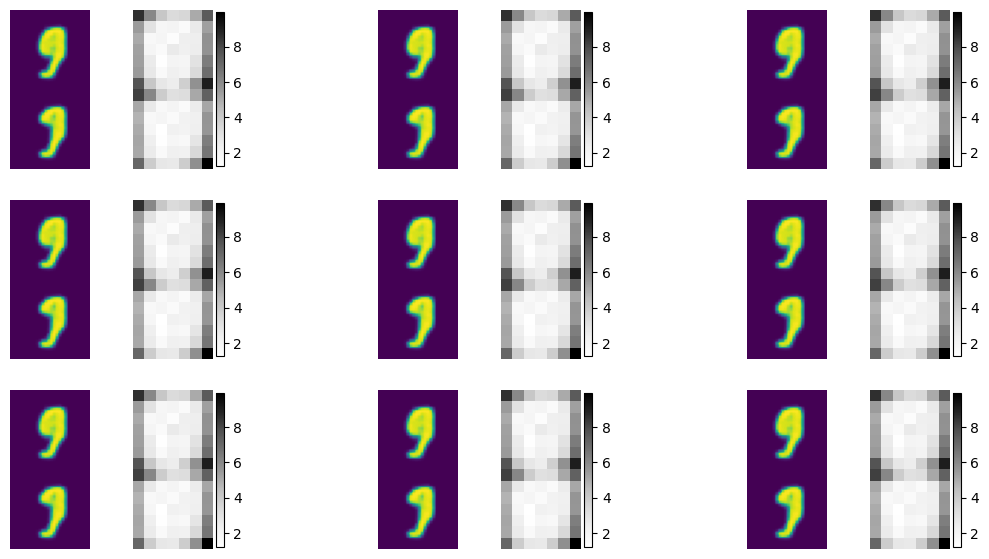

In [ ]:
#plot ten images of the largest _logit values reshaped into (14,7) with a shared colorbar range
#$
n_rec = 9
plt.figure(figsize=(14,7))
for i in range(n_rec):
    plt.subplot(3,n_rec,3*i+1)
    plt.imshow(decoded[i].reshape(56,28))
    plt.axis('off')
    plt.subplot(3,n_rec,3*i+2)
    plt.imshow(confidence[i].reshape(14,7),cmap='Greys')
    plt.axis('off')
    plt.colorbar(fraction=0.075, pad=0.04)
    #plt.subplot(3,n_rec,3*i+3)
    #plt.imshow(a[i].reshape(14,7),cmap='RdGy_r')

    plt.axis('off')

plt.show()

In [ ]:
def custom_mask(data,attention):
  n_samples=data.shape[0]
  n_tokens=98
  mask_token=0
  #flattenend_data=data.reshape((n_samples, n_tokens, data.shape[2]))
  masked_data = np.copy(data)
  masked_data[~attention] = mask_token
  return masked_data




In [ ]:
mod0_unmasked_test_x = half_mask(mod0_test_x[:n_rec],0,0)
n_rec=9
repeats=2
attended= np.zeros((repeats+1,n_rec,98),dtype=bool)
att = mod0_masked_test_x[:,:,0] !=0
conf=np.zeros((repeats+1,n_rec,98))
conf[0]=confidence
path=np.zeros((n_rec,98))
input=np.zeros((repeats+1,n_rec,98,64))
inp=np.copy(mod0_masked_test_x)
input[0]=inp

#min_indices = np.argmin(confidence, axis=-1)
#rows = np.arange(n_rec)
#att[rows, min_indices] = 1

min_indices = np.argpartition(confidence, 10, axis=-1)[:, :10]
rows = np.arange(n_rec)[:, None]
att[rows, min_indices] = 1



inp= custom_mask(mod0_unmasked_test_x[:n_rec],att)
input[1]=inp

reconstructions = model0.predict({'inputs_embeds': inp[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=n_rec)
logits = reconstructions.logits

confidence=logits.max(axis=-1)


most_probable1 = logits.argmax(axis=-1)
dec1, dec2 = decode(most_probable1, codes_sampler)
decoded=np.hstack((dec1, dec2))





1/1 [==============================] - 0s 23ms/step


ValueError: cannot reshape array of size 14112 into shape (56,28)

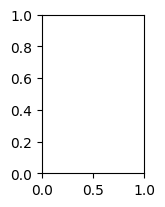

In [ ]:
n_rec = 9
plt.figure(figsize=(14,7))
for i in range(n_rec):
    plt.subplot(3,n_rec,3*i+1)
    plt.imshow(decoded[i].reshape(56,28))
    plt.axis('off')
    plt.subplot(3,n_rec,3*i+2)
    plt.imshow(confidence[i].reshape(14,7),cmap='Greys')
    plt.axis('off')
    plt.colorbar(fraction=0.075, pad=0.04)
    plt.subplot(3,n_rec,3*i+3)
    plt.imshow(inp[i,:,0].reshape(14,7),cmap='RdGy_r')
    plt.colorbar(fraction=0.075, pad=0.04)
    plt.axis('off')

plt.show()

In [ ]:
mod0_unmasked_test_x = half_mask(mod0_test_x[:n_rec],0,0)
n_rec=9
repeats=98
attended= np.zeros((repeats+1,n_rec,98),dtype=bool)
att = mod0_masked_test_x[:,:,0] !=0
conf=np.zeros((repeats+1,n_rec,98))
conf[0]=confidence
path=np.zeros((n_rec,98))
input=np.zeros((repeats+1,n_rec,98,64))
inp=np.copy(mod0_masked_test_x)
input[0]=inp
decoded=np.zeros((repeats+1,n_rec,56,28,1))

for n in range(repeats):
  min_indices = np.argmin(confidence, axis=-1)
  rows = np.arange(n_rec)
  att[rows, min_indices] = 1
  attended[n]=att
  inp= custom_mask(mod0_unmasked_test_x[:n_rec],att)
  input[n+1]=inp
  reconstructions = model0.predict({'inputs_embeds': inp[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=n_rec)
  logits = reconstructions.logits
  confidence=logits.max(axis=-1)
  conf[n+1]=confidence
  most_probable = logits.argmax(axis=-1)
  dec1, dec2 = decode(most_probable, codes_sampler)
  decoded[n]=np.hstack((dec1, dec2))




1/1 [==============================] - 0s 25ms/step


"\n\n  confidence[att]=0\n  conf[n+1]=confidence\n  next_p= confidence.argmin(axis=-1)\n  path[range(n_rec),next_p]=n\n  next_v= logits[range(n_rec),next_p].argmax(axis=-1)\n  inp[range(n_rec),next_p] = codebooks[next_v]\n  att[range(n_rec),next_p]= True\n  attended[n]=att\n  input[n+1]=inp\n  reconstructions = model0.predict({'inputs_embeds': inp[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=n_rec)\n  logits = reconstructions.logits\n  logits= tf.nn.softmax(logits, axis=-1).numpy()\n  confidence=logits.max(axis=-1)\n"

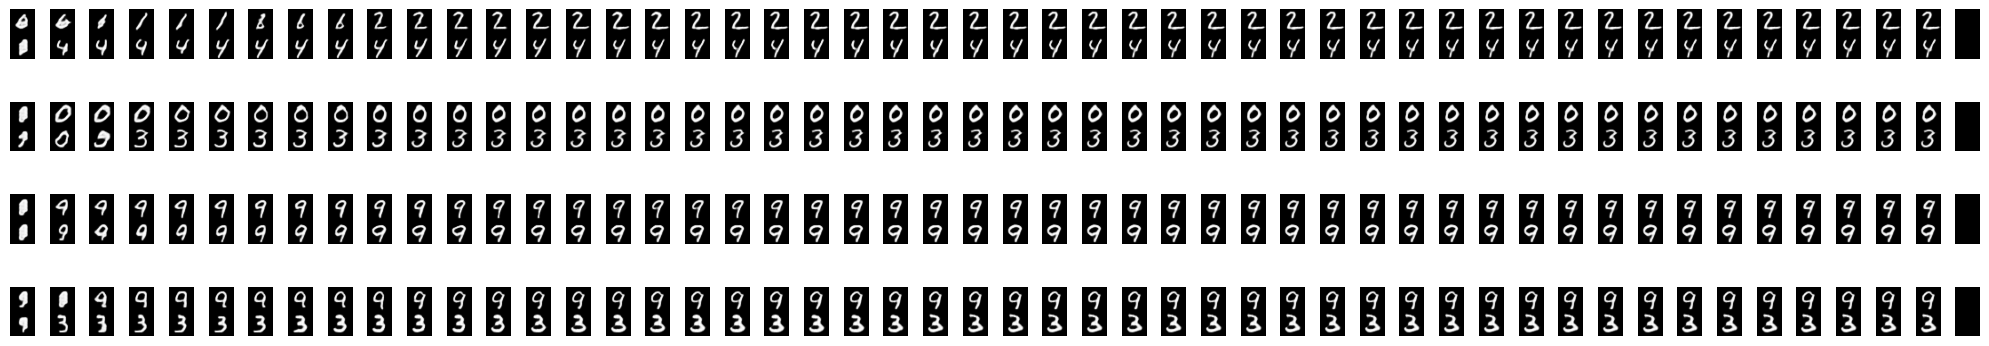

In [ ]:
# prompt: make a plot that consist of 5 rows and 5 columns and in each row plot the decoded data
R=4
C=50
fig, axes = plt.subplots(R, C, figsize=(20, 4))

for row in range(R):
  for col in range(C):
   # index = row * 5 + col  # Index of the image to plot

    axes[row, col].imshow(decoded[2*col,row, :, :, 0], cmap='gray')
    axes[row, col].axis('off')


plt.tight_layout()
plt.show()


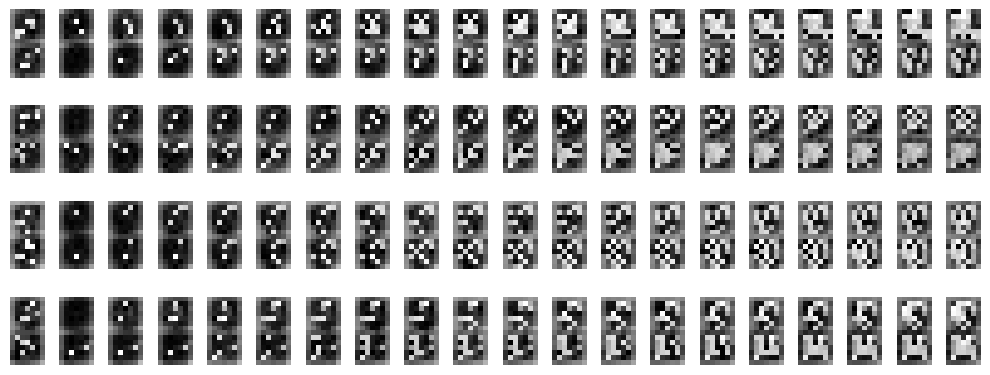

In [ ]:

fig, axes = plt.subplots(4, 20, figsize=(10, 4))

for row in range(4):
  for col in range(20):
   # index = row * 5 + col  # Index of the image to plot

    axes[row, col].imshow(conf[2*col,row, :].reshape(14,7), cmap='gray')
    axes[row, col].axis('off')


plt.tight_layout()
plt.show()

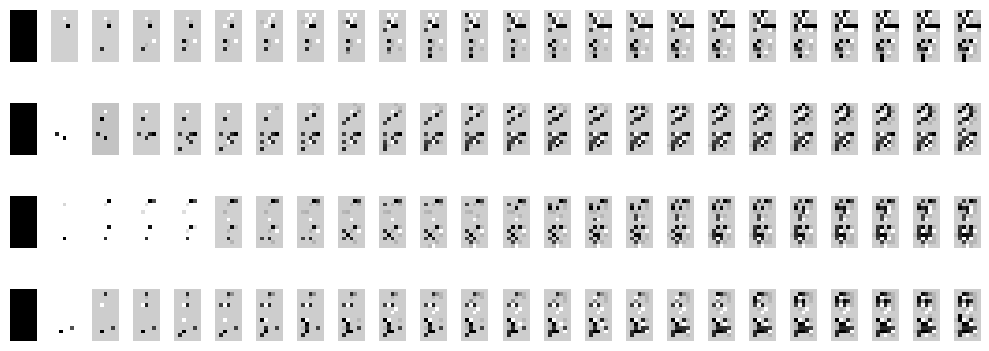

In [ ]:

fig, axes = plt.subplots(4, 24, figsize=(10, 4))

for row in range(4):
  for col in range(24):
   # index = row * 5 + col  # Index of the image to plot

    axes[row, col].imshow(input[2*col,row, :,0].reshape(14,7), cmap='gray')
    axes[row, col].axis('off')


plt.tight_layout()
plt.show()

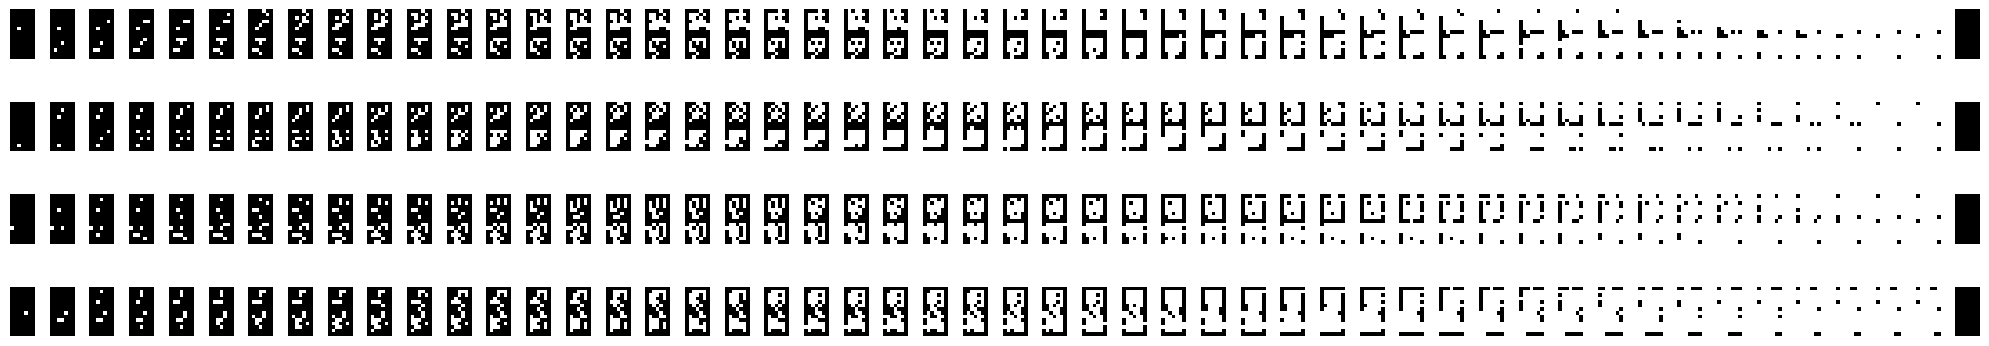

In [ ]:
R=4
C=50
fig, axes = plt.subplots(R, C, figsize=(20, 4))

for row in range(R):
  for col in range(C):
   # index = row * 5 + col  # Index of the image to plot

    axes[row, col].imshow(attended[2*col,row, :].reshape(14,7), cmap='gray')
    axes[row, col].axis('off')


plt.tight_layout()
plt.show()

In [ ]:
##this code should be adopted for additive attention



n_rec = 500
mask_levels=np.array([0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99])
mask_levels=np.round(mask_levels*98).astype('int')

#n = mask_levels.size
n=12
error1 = np.zeros(n)
error2 = np.zeros(n)
errors_total = np.zeros(n)
evals=np.zeros(n)
semantic_error=np.zeros(n)
Congruency="congruent"
held_out= False
y_test=mod0_y_test[:n_rec]


mod0_masked_test_x = half_mask(mod0_test_x[:n_rec],0,0)
#masked_test_x = mod0_test_x.reshape(( masked_test_x.shape[0], n_tokens))
reconstructions = model0.predict({'inputs_embeds': mod0_masked_test_x.astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)
logits = reconstructions.logits
most_probable = logits.argmax(axis=-1)
confidence=logits.max(axis=-1)

sorted_conf= np.sort(confidence,axis=-1)

for i in tqdm(range(n)):
  thresh=sorted_conf[:,mask_levels[i]]
  mask=confidence<thresh[:,np.newaxis]
  conf_temp=np.copy(confidence)
  data=np.copy(mod0_masked_test_x)
  data[mask]=0
  reconstructions = model0.predict({'inputs_embeds': data.astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)
  logits = reconstructions.logits
  most_probable = logits.argmax(axis=-1)
  decoded1, decoded2 = decode(most_probable, codes_sampler)
  class1=classifier.predict(decoded1).argmax(axis=-1)
  class2=classifier.predict(decoded2).argmax(axis=-1)
  error1[i]= (class1 != y_test//10).mean()
  error2[i]= (class2 != y_test%10).mean()
  errors_total[i] = (class1*10 + class2 != y_test).mean()
  if Congruency:
    congttl='Congruent'
    semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0) & (class1*10 + class2 != 0)).mean()
  elif Congruency or not held_out:
    semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0)& (class1*10 + class2 != 0)).mean()
    congttl='Incongruent'
  elif held_out:
    semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0)& (class1*10 + class2 != 0)).mean()
    congttl='Congruent heldout'

  #evals[i]=model0.evaluate({'inputs_embeds': masked_test_x.astype('float32'), 'labels': test_y.astype('float32')}, batch_size=256)
  Title=congttl


##statistics
we discuss it **later**

In [ ]:



mask_levels=np.zeros((n_rec, repeats+1))
for i in range(n_rec):
  mask_levels[i]=(49-np.count_nonzero(attended[:,i,49:], axis=-1))/0.49

error1 = np.zeros(repeats)
error2 = np.zeros(repeats)
errors_total = np.zeros(repeats)
evals=np.zeros(repeats)
semantic_error=np.zeros(repeats)
Congruency="congruent"
held_out= False
y_test=mod0_y_test[:n_rec]
for i in tqdm(range(repeats)):
  masked_test_x = mod0_test_x[:n_rec]
  masked_test_x[-attended[i]]=0
  reconstructions = model.predict({'inputs_embeds': masked_test_x.astype('float32'), 'labels': test_y.astype('float32')}, batch_size=256)
  most_probable = logits_all[i].argmax(axis=-1)
  decoded1, decoded2 = decode(most_probable, codes_sampler)
  class1=classifier.predict(decoded1).argmax(axis=-1)
  class2=classifier.predict(decoded2).argmax(axis=-1)
  error1[i]= (class1 != y_test//10).mean()
  error2[i]= (class2 != y_test%10).mean()
  errors_total[i] = (class1*10 + class2 != y_test).mean()
  if Congruency:
    congttl='Congruent'
    semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0) & (class1*10 + class2 != 0)).mean()
  elif Congruency or not held_out:
    semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0)& (class1*10 + class2 != 0)).mean()
    congttl='Incongruent'
  elif held_out:
    semantic_error[i]=((class1*10 + class2 != y_test) & ((class1*10 + class2)%3==0)& (class1*10 + class2 != 0)).mean()
    congttl='Congruent heldout'

  #evals[i]=model0.evaluate({'inputs_embeds': masked_test_x.astype('float32'), 'labels': test_y.astype('float32')}, batch_size=256)
  Title=congttl

In [ ]:
i=4

In [ ]:
#masked values are false
initial_info= mod0_masked_test_x[:,:,0]!=0
next_m= initial_info

In [ ]:
print(next_m[4])

[ True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False  True False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False  True
  True False]


In [ ]:
confidence[next_m]=0

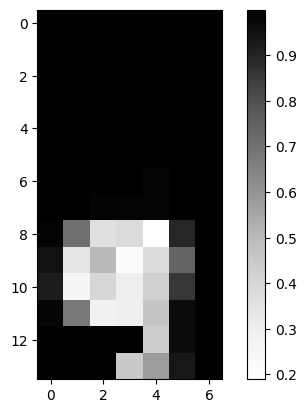

In [ ]:
plt.imshow(confidence2[7].reshape(14,7),cmap='Greys')
plt.colorbar()

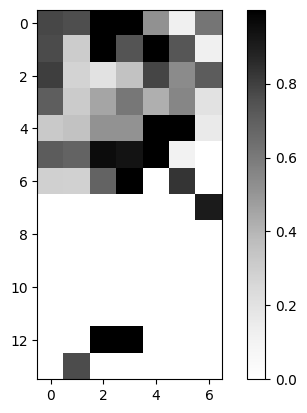

In [ ]:
plt.imshow(confidence[7].reshape(14,7),cmap='Greys')
plt.colorbar()

In [ ]:
print(confidence[6].reshape(14,7))

[[0.198032   0.13842015 0.20187603 0.2495796  0.33076423 0.99999905
  0.18772018]
 [0.18881622 0.19775179 0.99994946 0.28487074 0.74025553 0.9999999
  0.999997  ]
 [0.19876994 0.35469094 0.9999993  0.2534049  0.9999409  0.04963865
  0.20380168]
 [0.16889599 0.36279726 0.7225194  0.7981716  0.22523084 0.30428594
  0.18923965]
 [0.17569709 0.28100324 0.37594146 0.5655516  0.2875456  0.16645978
  0.23686086]
 [0.1834253  0.9999945  0.30368572 0.379054   0.6124112  0.12001462
  0.23628397]
 [0.21970128 0.87691736 0.99988556 0.29810444 0.26458246 0.16941224
  0.2028449 ]
 [0.71395904 0.17895295 0.3741928  0.26071307 0.2850417  0.2564773
  0.53563   ]
 [0.49652216 0.36242676 0.99985206 0.5497931  0.7761501  0.39673075
  0.6270593 ]
 [0.36486527 0.4103304  0.5439854  0.6291138  0.17616582 0.21619053
  0.76000214]
 [0.6496429  0.33086902 0.43897355 0.4731996  0.6565428  0.13480385
  0.30196705]
 [0.5946256  0.27393657 0.6067714  0.7874317  0.6313273  0.3050472
  0.1571877 ]
 [0.23334758 0.4205

In [ ]:
print(logits[5])

[[-13.106885    -4.0318923   -1.2589062  ... -16.920784   -11.133722
    1.2696792 ]
 [-13.922729    -1.1201016    0.17517984 ... -14.249431   -11.8889675
    1.7079293 ]
 [-13.998658     0.45349443   0.8558692  ... -16.119514   -11.7958355
    1.766254  ]
 ...
 [ -9.434511    -6.4354424   -3.3763728  ... -14.561585   -11.483436
   -2.5764267 ]
 [-11.352944    -8.327926    -4.433138   ... -15.827919   -10.2669325
    1.0043709 ]
 [-12.305873    -6.7818446   -4.4097047  ... -18.82528     -9.352174
   -0.6040319 ]]


In [ ]:
next_p = confidence.argmax(axis=-1)

In [ ]:
print(next_p)

[93 49 70 90 55 77 92 49 93]


In [ ]:
next_v= logits[range(n_rec),next_p].argmax(axis=-1)

In [ ]:
print(next_v)

[ 7 10 10  7 13  5  8 10 14]


In [ ]:
mod0_masked_test_x[range(n_rec),next_p] = codebooks[next_v]

In [ ]:
next_m[range(n_rec),next_p]= True


In [ ]:
reconstructions = model0.predict({'inputs_embeds': mod0_masked_test_x[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)
logits = reconstructions.logits

1/1 [==============================] - 0s 31ms/step


In [ ]:
confidence=logits.max(axis=-1)

In [ ]:
next_p = confidence[i].argmax()

In [ ]:
reconstructions = model0.predict({'inputs_embeds': mod0_masked_test_x[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)

logits = reconstructions.logits
logits=softmax(logits, axis=-1)
confidence=logits.max(axis=-1)

1/1 [==============================] - 0s 35ms/step


In [ ]:
i=3
n_rec=9
repeats=49
mask= np.zeros((repeats+1,n_rec,98),dtype=bool)
msk = mod0_masked_test_x[i,:,0]!=0
conf=np.zeros((repeats+1,n_rec,98))
conf[0]=confidence
for n in range(repeats):
  confidence[i,msk]=0
  conf[n+1]=confidence
  next_p= confidence[i].argmax(axis=-1)
  next_v= logits[i,next_p].argmax()
  mod0_masked_test_x[i,next_p] = codebooks[next_v]
  msk[next_p]= True
  mask[n]=msk
  reconstructions = model0.predict({'inputs_embeds': mod0_masked_test_x[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)
  logits = reconstructions.logits
  logits=softmax(logits)
  confidence=logits.max(axis=-1)


1/1 [==============================] - 0s 29ms/step


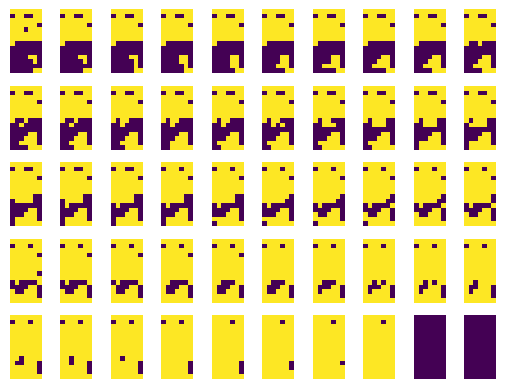

In [ ]:
#plot 10 images of mask reshaped into (14,7)
for i in range(repeats+1):
    plt.subplot(5,10,i+1)
    plt.imshow(mask[i,3,:].reshape(14,7))
    plt.axis('off')
    #plt.colorbar()
plt.show()

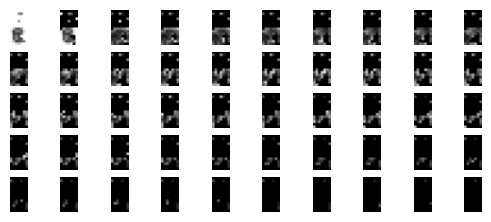

In [ ]:
#plot 10 images of mask reshaped into (14,7)
for i in range(repeats+1):
    plt.subplot(9,10,i+1)
    plt.imshow(conf[i,3,:].reshape(14,7), cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.show()

In [ ]:
print(np.min(conf),np.max(conf))

0.0 1.0


In [ ]:
n_rec = 9
mod0_masked_test_x = half_mask(mod0_test_x[:n_rec],0.1,0.9)
reconstructions = model0.predict({'inputs_embeds': mod0_masked_test_x[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)

logits = reconstructions.logits
#logits= tf.nn.softmax(logits, axis=-1).numpy()

confidence=logits.max(axis=-1)

1/1 [==============================] - 0s 28ms/step


In [ ]:
logits = reconstructions.logits
logits= tf.nn.softmax(logits, axis=-1).numpy()

confidence=logits.max(axis=-1)

In [ ]:
print(next_p)

[68 79 54  0  0 67 78 94  0]


In [ ]:

#Extended updating of masked values
n_rec=9
repeats=49
attended= np.zeros((repeats+1,n_rec,98),dtype=bool)
att = mod0_masked_test_x[:,:,0]!=0
conf=np.zeros((repeats+1,n_rec,98))
conf[0]=confidence
path=np.zeros((n_rec,98))
input=np.zeros((repeats+1,n_rec,98,64))
inp=np.copy(mod0_masked_test_x)
input[0]=inp
for n in range(repeats):
  confidence[att]=0
  conf[n+1]=confidence
  next_p= confidence.argmax(axis=-1)
  path[range(n_rec),next_p]=n
  next_v= logits[range(n_rec),next_p].argmax(axis=-1)
  inp[range(n_rec),next_p] = codebooks[next_v]
  att[range(n_rec),next_p]= True
  attended[n]=att
  input[n+1]=inp
  reconstructions = model0.predict({'inputs_embeds': inp[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=n_rec)
  logits = reconstructions.logits
  logits= tf.nn.softmax(logits, axis=-1).numpy()
  confidence=logits.max(axis=-1)

1/1 [==============================] - 0s 25ms/step


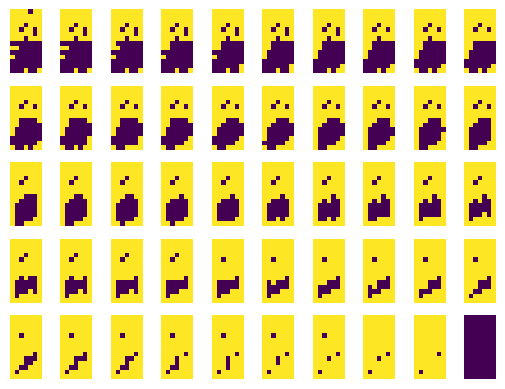

In [ ]:
#plot 10 images of mask reshaped into (14,7)
v=2
for i in range(repeats+1):
    plt.subplot(5,10,i+1)
    plt.imshow(attended[i,8,:].reshape(14,7))
    plt.axis('off')
plt.show()

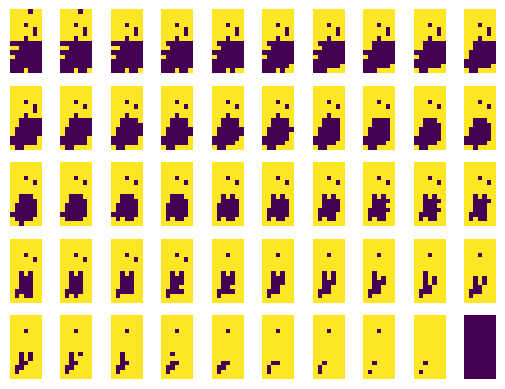

In [ ]:
#plot 10 images of mask reshaped into (14,7)
v=2
for i in range(repeats+1):
    plt.subplot(5,10,i+1)
    plt.imshow(attended[i,8,:].reshape(14,7))
    plt.axis('off')
plt.show()

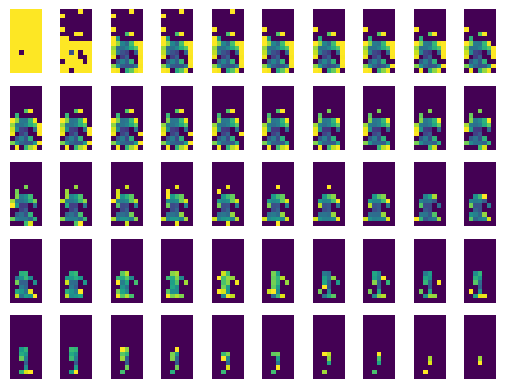

In [ ]:
#plot 10 images of mask reshaped into (14,7)
for i in range(repeats+1):
    plt.subplot(5,10,i+1)
    plt.imshow(conf[i,4,:].reshape(14,7))#, cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.show()

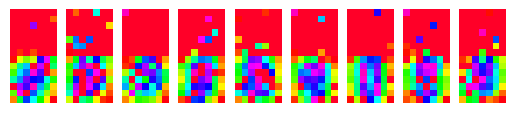

In [ ]:
for i in range(n_rec):
    plt.subplot(1,n_rec,i+1)
    plt.imshow(path[i,:].reshape(14,7), cmap='gist_rainbow')
    plt.axis('off')
plt.show()

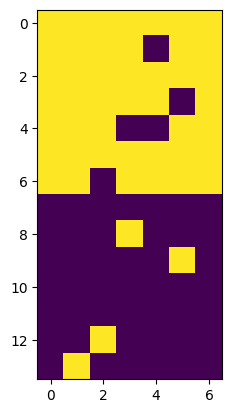

interactive(children=(IntSlider(value=0, description='t', max=49), Output()), _dom_classes=('widget-interact',…

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import numpy.random as npr
i=3
images = attended[:,i,:].reshape(-1, 14, 7)

def slider_animation(images):
    # images is a numpy array that contains a list of rgb or rgba images for imshow
    fig, ax = plt.subplots()
    im = ax.imshow(images[0])
    plt.close()
    hfig = display(fig, display_id=True)

    def update(t):
        im.set_data(images[t])
        fig.canvas.draw_idle()
        hfig.update(fig)

    interact(update, t=widgets.IntSlider(value=0, min=0, max=len(images)-1))

slider_animation(images)

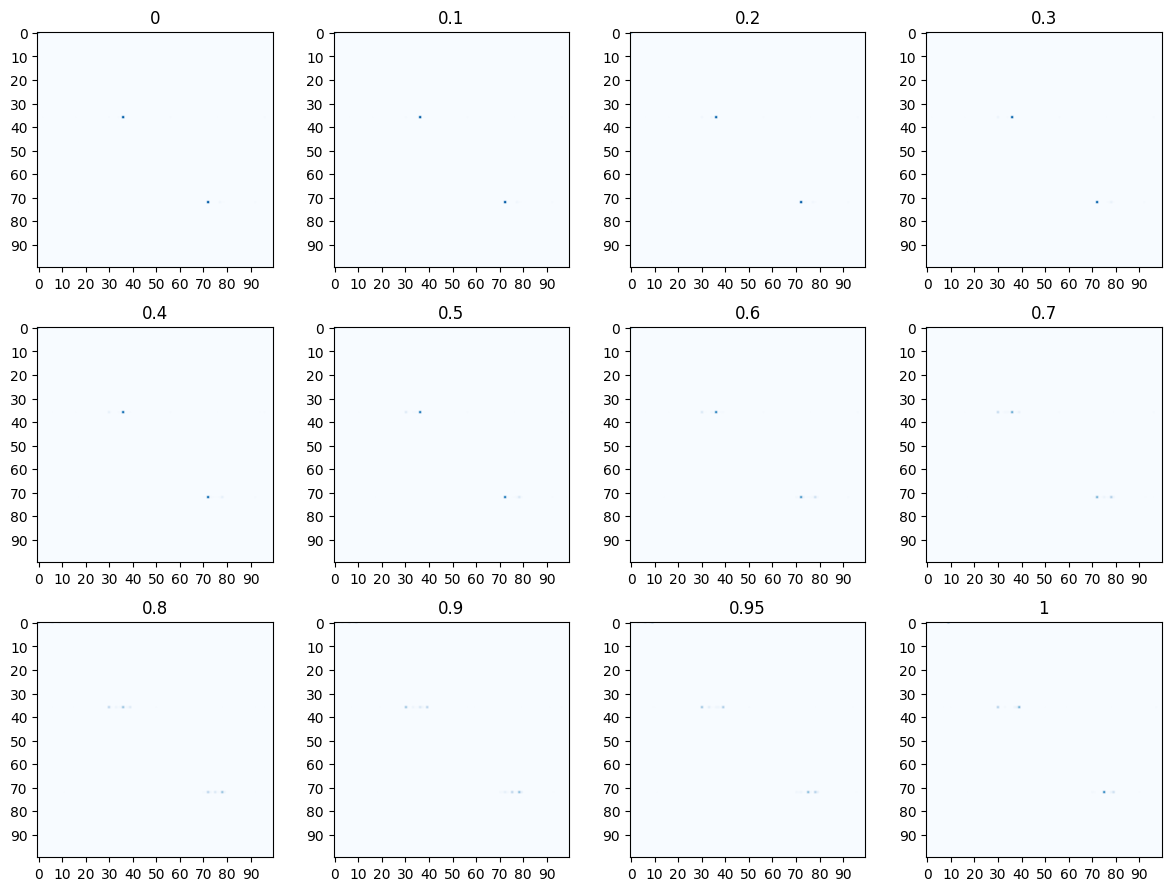

In [ ]:
# plot all the schema matrixes in a large subplot
mask_levels=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
vmin=Schema_heldout.min()
vmax=Schema_heldout.max()
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for i in range(3):
  for j in range(4):
    im = axs[i, j].imshow(Schema_heldout[i*4+j], cmap='Blues',vmin=vmin, vmax=vmax)
    axs[i, j].set_title(mask_levels[i*4+j])
    axs[i, j].set_xticks(np.arange(100,step=10))
    axs[i, j].set_yticks(np.arange(100,step=10))
    axs[i, j].set_xticklabels(np.arange(100,step=10))
    axs[i, j].set_yticklabels(np.arange(100,step=10))
    axs[i, j].grid(False)
fig.tight_layout()

## Confusion matrix of number changes

In [ ]:
def Schema_matrix(model,test_x,test_y,y_test):
  mask_levels=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
  n = len(mask_levels)
  schemas=np.zeros((n,10,10))
  for m in tqdm(range(n)):
    mask_perc=mask_levels[m]
    masked_test_x=half_mask(test_x,0,mask_perc)
    #masked_test_x=mask(test_x,mask_perc)
    reconstructions = model.predict({'inputs_embeds': masked_test_x.astype('float32'), 'labels': test_y.astype('float32')}, batch_size=256)
    logits = reconstructions.logits
    most_probable = logits.argmax(axis=-1)
    decoded1, decoded2 = decode(most_probable, codes_sampler)
    class1=classifier.predict(decoded1).argmax(axis=-1)
    class2=classifier.predict(decoded2).argmax(axis=-1)
    digit1=y_test//10
    digit2=y_test%10
    for i in range(10):
      for j in range(10):
        schemas[m,i,j]=(((digit2==i)&((class2==j))).mean())
  return schemas

In [ ]:
schema= Schema_matrix(model0,mod0_test_x,mod0_test_y,mod0_y_test)

  0%|          | 0/12 [00:00<?, ?it/s]

192/192 [==============================] - 0s 2ms/step


  8%|▊         | 1/12 [00:03<00:33,  3.05s/it]

192/192 [==============================] - 0s 2ms/step


 17%|█▋        | 2/12 [00:05<00:29,  2.97s/it]

192/192 [==============================] - 0s 2ms/step


 25%|██▌       | 3/12 [00:08<00:26,  2.97s/it]

192/192 [==============================] - 0s 2ms/step


 33%|███▎      | 4/12 [00:11<00:23,  2.96s/it]

192/192 [==============================] - 0s 2ms/step


 42%|████▏     | 5/12 [00:15<00:21,  3.13s/it]

192/192 [==============================] - 0s 2ms/step


 50%|█████     | 6/12 [00:18<00:18,  3.06s/it]

192/192 [==============================] - 0s 2ms/step


 58%|█████▊    | 7/12 [00:21<00:15,  3.04s/it]

192/192 [==============================] - 0s 2ms/step


 67%|██████▋   | 8/12 [00:24<00:12,  3.03s/it]

192/192 [==============================] - 0s 2ms/step


 75%|███████▌  | 9/12 [00:27<00:09,  3.02s/it]

192/192 [==============================] - 0s 2ms/step


 83%|████████▎ | 10/12 [00:30<00:05,  3.00s/it]

192/192 [==============================] - 0s 2ms/step


 92%|█████████▏| 11/12 [00:33<00:03,  3.01s/it]

192/192 [==============================] - 0s 2ms/step


100%|██████████| 12/12 [00:36<00:00,  3.02s/it]


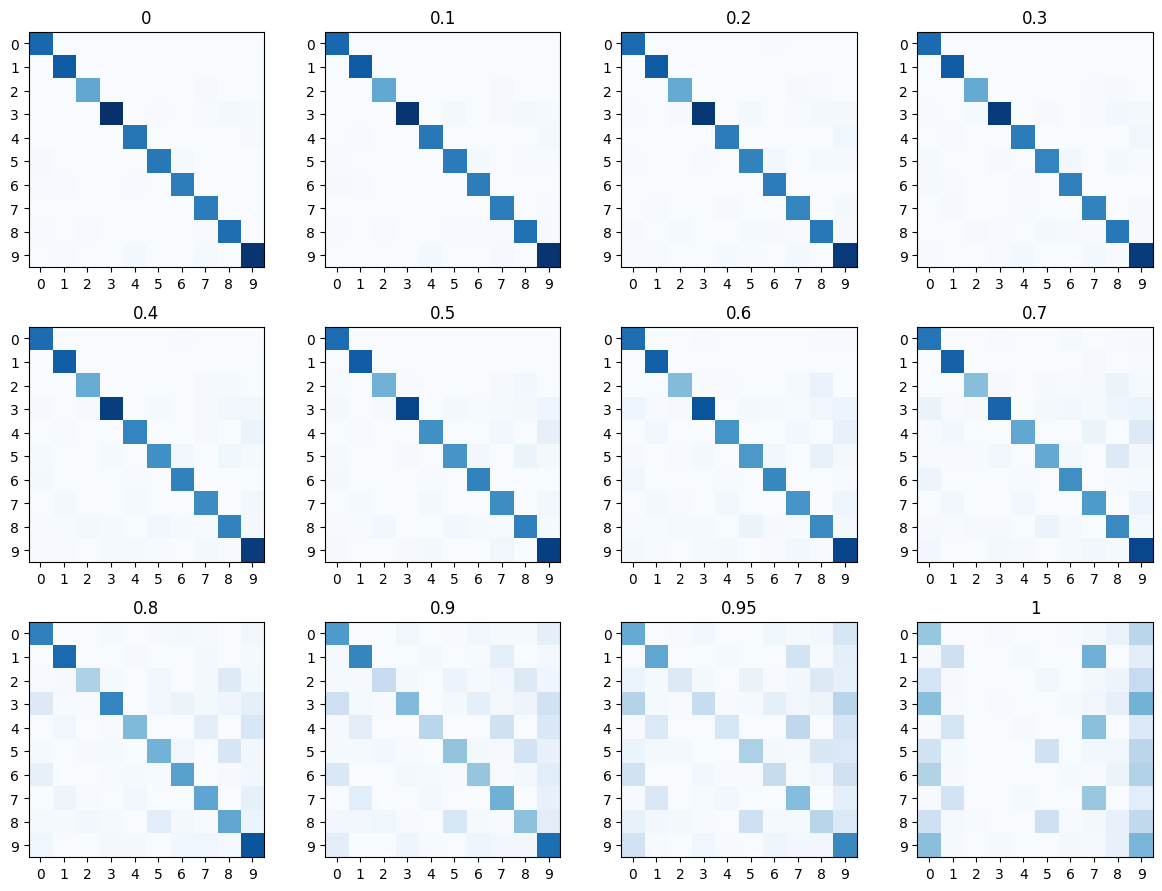

In [ ]:
# plot all the schema matrixes in a large subplot
mask_levels=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
vmin=schema.min()
vmax=schema.max()
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for i in range(3):
  for j in range(4):
    im = axs[i, j].imshow(schema[i*4+j], cmap='Blues',vmin=vmin, vmax=vmax)
    axs[i, j].set_title(mask_levels[i*4+j])
    axs[i, j].set_xticks(np.arange(10))
    axs[i, j].set_yticks(np.arange(10))
    axs[i, j].set_xticklabels(np.arange(10))
    axs[i, j].set_yticklabels(np.arange(10))
    axs[i, j].grid(False)
fig.tight_layout()

In [ ]:
schema_inc= Schema_matrix(model0,mod1_test_x,mod1_test_y,mod1_y_test)

  0%|          | 0/12 [00:00<?, ?it/s]

412/412 [==============================] - 1s 2ms/step


  8%|▊         | 1/12 [00:06<01:07,  6.16s/it]

412/412 [==============================] - 1s 2ms/step


 17%|█▋        | 2/12 [00:12<01:02,  6.26s/it]

412/412 [==============================] - 1s 2ms/step


 25%|██▌       | 3/12 [00:18<00:56,  6.31s/it]

412/412 [==============================] - 1s 2ms/step


 33%|███▎      | 4/12 [00:25<00:50,  6.26s/it]

412/412 [==============================] - 1s 2ms/step


 42%|████▏     | 5/12 [00:31<00:43,  6.28s/it]

412/412 [==============================] - 1s 2ms/step


 50%|█████     | 6/12 [00:37<00:37,  6.26s/it]

412/412 [==============================] - 1s 2ms/step


 58%|█████▊    | 7/12 [00:43<00:31,  6.26s/it]

412/412 [==============================] - 1s 2ms/step


 67%|██████▋   | 8/12 [00:50<00:25,  6.27s/it]

412/412 [==============================] - 1s 2ms/step


 75%|███████▌  | 9/12 [00:56<00:18,  6.26s/it]

412/412 [==============================] - 1s 2ms/step


 83%|████████▎ | 10/12 [01:02<00:12,  6.19s/it]

412/412 [==============================] - 1s 2ms/step


 92%|█████████▏| 11/12 [01:08<00:06,  6.20s/it]

412/412 [==============================] - 1s 2ms/step


100%|██████████| 12/12 [01:14<00:00,  6.24s/it]


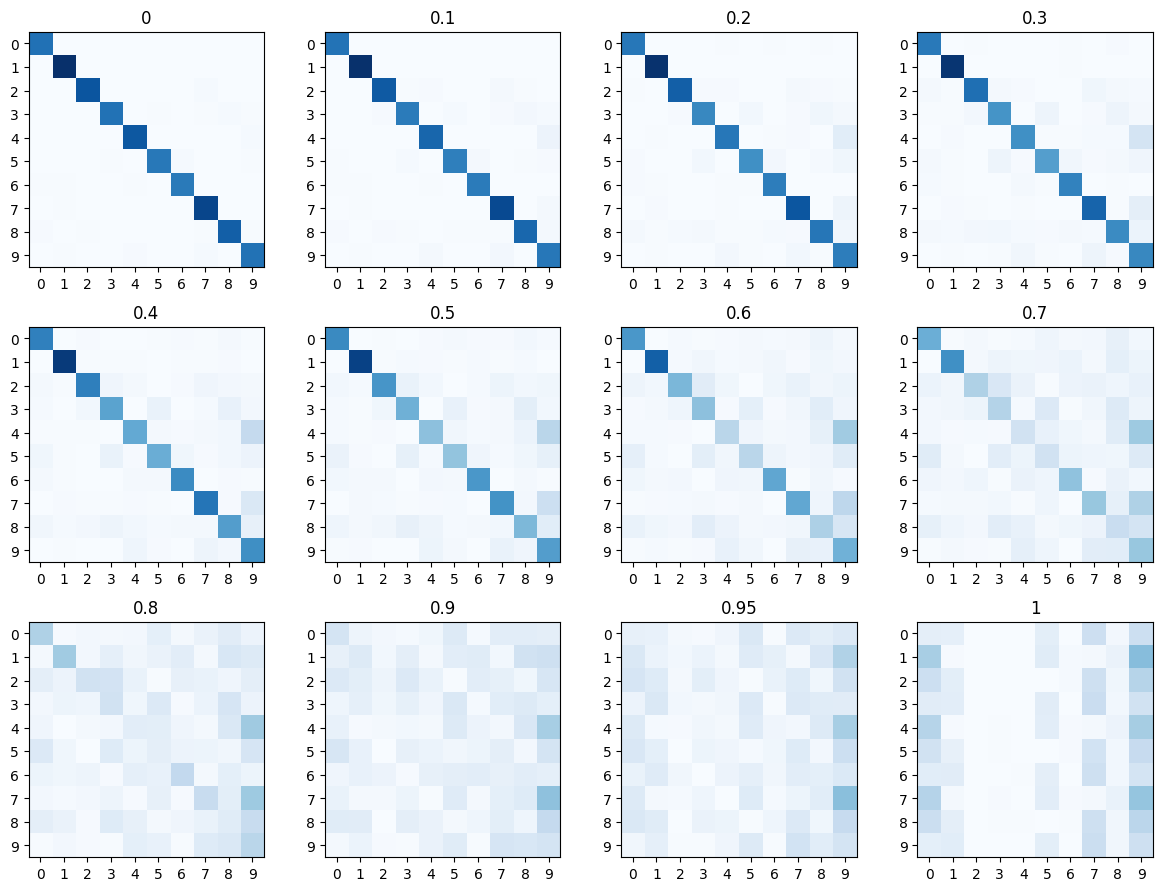

In [ ]:
# plot all the schema matrixes in a large subplot
mask_levels=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
vmin=schema_inc.min()
vmax=schema_inc.max()
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for i in range(3):
  for j in range(4):
    im = axs[i, j].imshow(schema_inc[i*4+j], cmap='Blues',vmin=vmin, vmax=vmax)
    axs[i, j].set_title(mask_levels[i*4+j])
    axs[i, j].set_xticks(np.arange(10))
    axs[i, j].set_yticks(np.arange(10))
    axs[i, j].set_xticklabels(np.arange(10))
    axs[i, j].set_yticklabels(np.arange(10))
    axs[i, j].grid(False)
fig.tight_layout()

In [ ]:
def Schema_matrix_100(model,test_x,test_y,y_test):
  mask_levels=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
  n = len(mask_levels)
  schemas=np.zeros((n,100,100))
  for m in tqdm(range(n)):
    mask_perc=mask_levels[m]
    masked_test_x=half_mask(test_x,0,mask_perc)
    #masked_test_x=mask(test_x,mask_perc)
    reconstructions = model.predict({'inputs_embeds': masked_test_x.astype('float32'), 'labels': test_y.astype('float32')}, batch_size=256)
    logits = reconstructions.logits
    most_probable = logits.argmax(axis=-1)
    decoded1, decoded2 = decode(most_probable, codes_sampler)
    class1=classifier.predict(decoded1).argmax(axis=-1)
    class2=classifier.predict(decoded2).argmax(axis=-1)
    number=class1*10+class2
    for i in range(100):
      for j in range(100):
        schemas[m,i,j]=(((y_test==i)&((number==j))).mean())
  return schemas

In [ ]:
schema_100= Schema_matrix_100(model0,mod0_test_x,mod0_test_y,mod0_y_test)

  0%|          | 0/12 [00:00<?, ?it/s]

192/192 [==============================] - 0s 2ms/step


  8%|▊         | 1/12 [00:03<00:36,  3.30s/it]

192/192 [==============================] - 0s 2ms/step


 17%|█▋        | 2/12 [00:06<00:32,  3.27s/it]

192/192 [==============================] - 0s 2ms/step


 25%|██▌       | 3/12 [00:09<00:29,  3.25s/it]

192/192 [==============================] - 0s 2ms/step


 33%|███▎      | 4/12 [00:13<00:25,  3.25s/it]

192/192 [==============================] - 0s 2ms/step


 42%|████▏     | 5/12 [00:16<00:22,  3.25s/it]

192/192 [==============================] - 0s 2ms/step


 50%|█████     | 6/12 [00:19<00:19,  3.24s/it]

192/192 [==============================] - 0s 2ms/step


 58%|█████▊    | 7/12 [00:22<00:16,  3.26s/it]

192/192 [==============================] - 0s 2ms/step


 67%|██████▋   | 8/12 [00:26<00:12,  3.25s/it]

192/192 [==============================] - 0s 2ms/step


 75%|███████▌  | 9/12 [00:29<00:09,  3.24s/it]

192/192 [==============================] - 0s 2ms/step


 83%|████████▎ | 10/12 [00:32<00:06,  3.23s/it]

192/192 [==============================] - 0s 2ms/step


 92%|█████████▏| 11/12 [00:35<00:03,  3.22s/it]

192/192 [==============================] - 0s 2ms/step


100%|██████████| 12/12 [00:38<00:00,  3.24s/it]


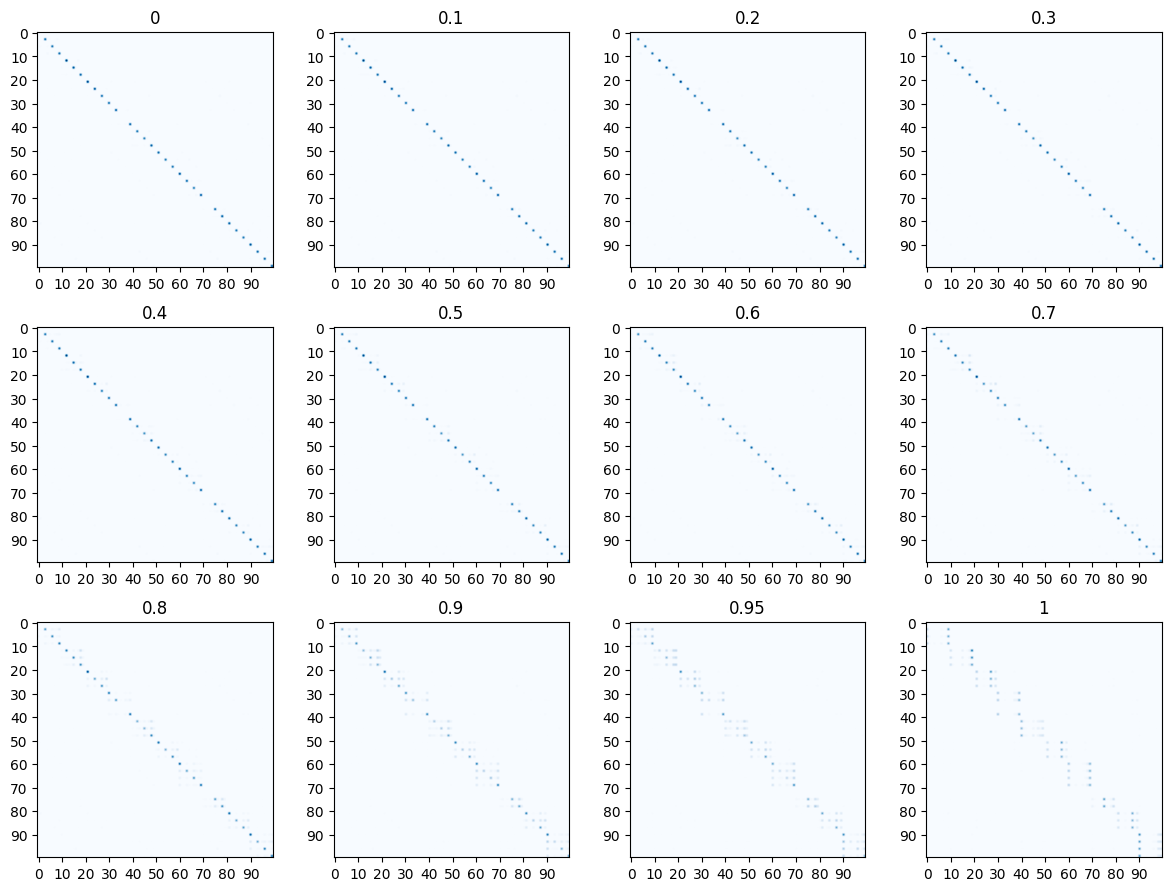

In [ ]:
# plot all the schema matrixes in a large subplot
mask_levels=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
vmin=schema_100.min()
vmax=schema_100.max()
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for i in range(3):
  for j in range(4):
    im = axs[i, j].imshow(schema_100[i*4+j], cmap='Blues',vmin=vmin, vmax=vmax)
    axs[i, j].set_title(mask_levels[i*4+j])
    axs[i, j].set_xticks(np.arange(100,step=10))
    axs[i, j].set_yticks(np.arange(100,step=10))
    axs[i, j].set_xticklabels(np.arange(100,step=10))
    axs[i, j].set_yticklabels(np.arange(100,step=10))
    axs[i, j].grid(False)
fig.tight_layout()

In [ ]:
Schema100_inc= Schema_matrix_100(model0,mod1_test_x,mod1_test_y,mod1_y_test)

  0%|          | 0/12 [00:00<?, ?it/s]

412/412 [==============================] - 1s 2ms/step


  8%|▊         | 1/12 [00:06<01:10,  6.40s/it]

412/412 [==============================] - 1s 2ms/step


 17%|█▋        | 2/12 [00:12<01:04,  6.44s/it]

412/412 [==============================] - 1s 2ms/step


 25%|██▌       | 3/12 [00:19<00:58,  6.51s/it]

412/412 [==============================] - 1s 2ms/step


 33%|███▎      | 4/12 [00:25<00:51,  6.50s/it]

412/412 [==============================] - 1s 2ms/step


 42%|████▏     | 5/12 [00:32<00:45,  6.52s/it]

412/412 [==============================] - 1s 2ms/step


 50%|█████     | 6/12 [00:39<00:40,  6.67s/it]

412/412 [==============================] - 1s 2ms/step


 58%|█████▊    | 7/12 [00:46<00:33,  6.72s/it]

412/412 [==============================] - 1s 2ms/step


 67%|██████▋   | 8/12 [00:52<00:26,  6.66s/it]

412/412 [==============================] - 1s 2ms/step


 75%|███████▌  | 9/12 [00:59<00:19,  6.65s/it]

412/412 [==============================] - 1s 2ms/step


 83%|████████▎ | 10/12 [01:05<00:13,  6.59s/it]

412/412 [==============================] - 1s 2ms/step


 92%|█████████▏| 11/12 [01:12<00:06,  6.61s/it]

412/412 [==============================] - 1s 2ms/step


100%|██████████| 12/12 [01:19<00:00,  6.60s/it]


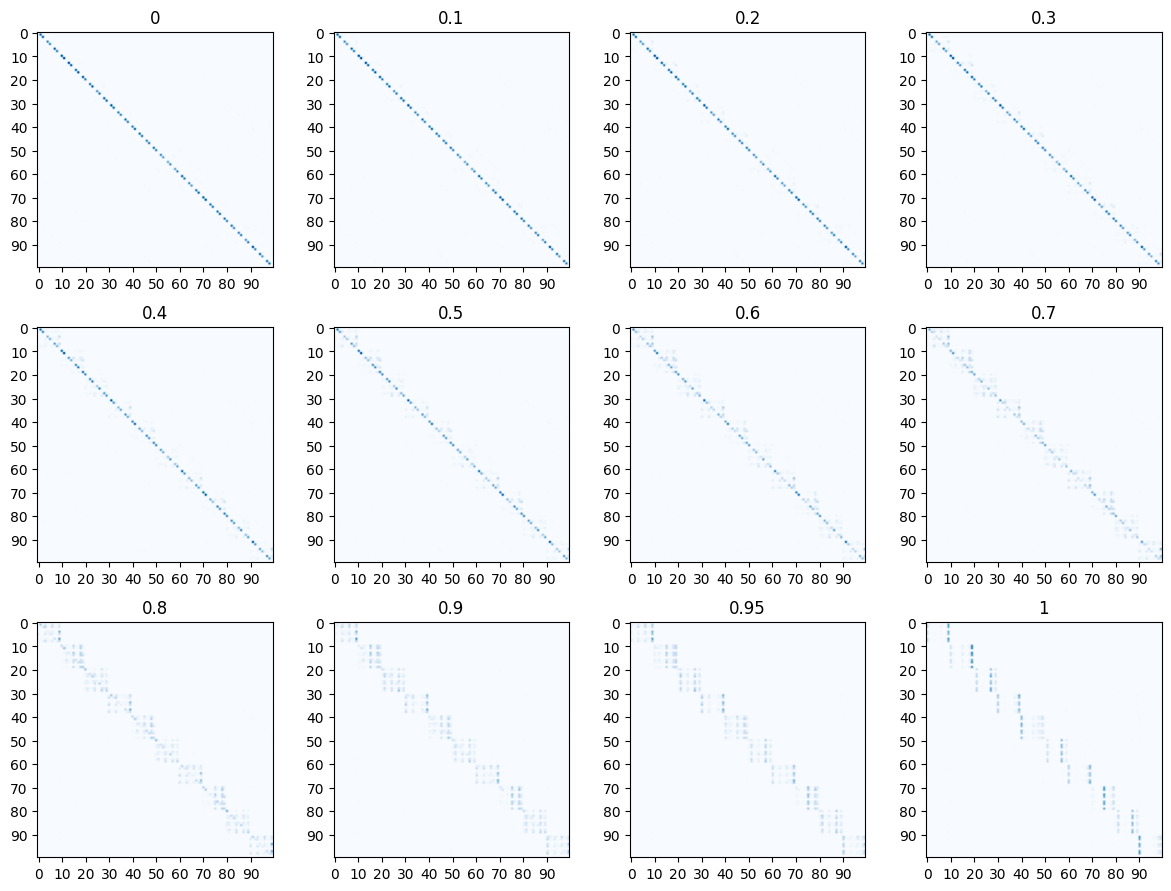

In [ ]:
# plot all the schema matrixes in a large subplot
mask_levels=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
vmin=Schema100_inc.min()
vmax=Schema100_inc.max()
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for i in range(3):
  for j in range(4):
    im = axs[i, j].imshow(Schema100_inc[i*4+j], cmap='Blues',vmin=vmin, vmax=vmax)
    axs[i, j].set_title(mask_levels[i*4+j])
    axs[i, j].set_xticks(np.arange(100,step=10))
    axs[i, j].set_yticks(np.arange(100,step=10))
    axs[i, j].set_xticklabels(np.arange(100,step=10))
    axs[i, j].set_yticklabels(np.arange(100,step=10))
    axs[i, j].grid(False)
fig.tight_layout()

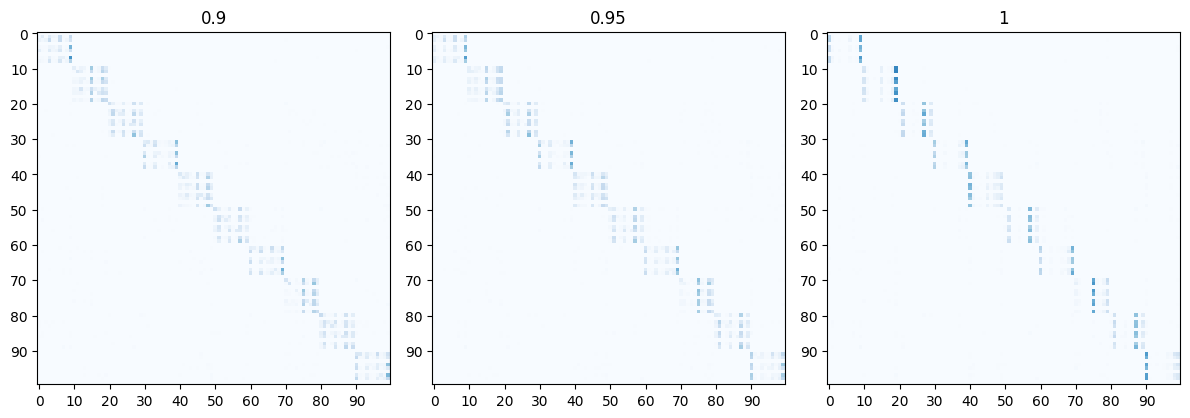

In [ ]:
# plot all the schema matrixes in a large subplot
mask_levels=[0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
vmin=Schema100_inc.min()
vmax=Schema100_inc.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(1):
  for j in range(3):
    im = axs[j].imshow(Schema100_inc[i+9+j], cmap='Blues',vmin=vmin, vmax=vmax)
    axs[ j].set_title(mask_levels[i+9+j])
    axs[ j].set_xticks(np.arange(100,step=10))
    axs[ j].set_yticks(np.arange(100,step=10))
    axs[ j].set_xticklabels(np.arange(100,step=10))
    axs[ j].set_yticklabels(np.arange(100,step=10))
    axs[ j].grid(False)
fig.tight_layout()

In [ ]:
Schema_heldout=Schema_matrix_100(model0,mod2_test_x,mod2_test_y,mod2_y_test)

  0%|          | 0/12 [00:00<?, ?it/s]

18/18 [==============================] - 0s 2ms/step


  8%|▊         | 1/12 [00:00<00:07,  1.42it/s]

18/18 [==============================] - 0s 2ms/step


 17%|█▋        | 2/12 [00:01<00:06,  1.48it/s]

18/18 [==============================] - 0s 2ms/step


 25%|██▌       | 3/12 [00:02<00:06,  1.49it/s]

18/18 [==============================] - 0s 2ms/step


 33%|███▎      | 4/12 [00:02<00:05,  1.52it/s]

18/18 [==============================] - 0s 2ms/step


 42%|████▏     | 5/12 [00:03<00:04,  1.53it/s]

18/18 [==============================] - 0s 2ms/step


 50%|█████     | 6/12 [00:03<00:03,  1.52it/s]

18/18 [==============================] - 0s 2ms/step


 58%|█████▊    | 7/12 [00:04<00:03,  1.51it/s]

18/18 [==============================] - 0s 2ms/step


 67%|██████▋   | 8/12 [00:05<00:02,  1.50it/s]

18/18 [==============================] - 0s 2ms/step


 75%|███████▌  | 9/12 [00:05<00:01,  1.50it/s]

18/18 [==============================] - 0s 2ms/step


 83%|████████▎ | 10/12 [00:06<00:01,  1.50it/s]

18/18 [==============================] - 0s 2ms/step


 92%|█████████▏| 11/12 [00:07<00:00,  1.50it/s]

18/18 [==============================] - 0s 2ms/step


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


##study codebook vectors

In [ ]:
digitup=np.zeros((14,7),dtype=bool)
digitup[1:6,1:6]=1
digitup=digitup.flatten()
digitdown=np.zeros((14,7),dtype=bool)
digitdown[8:13,1:6]=1
digitdown=digitdown.flatten()

digit=(digitup+digitdown).flatten()




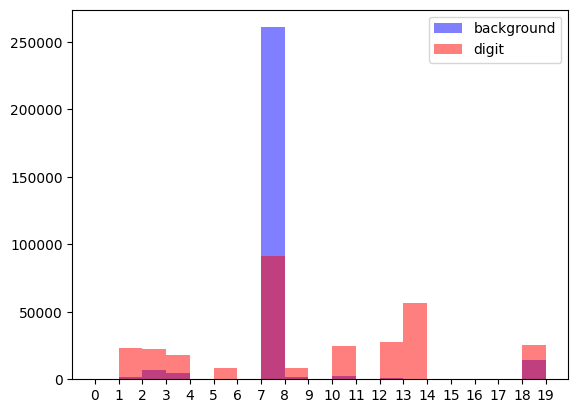

In [ ]:
plt.hist(mod0_test_y[:,~digit].flatten(), range(20), alpha=0.5, color='b')
plt.hist(mod0_test_y[:,digit].flatten(), range(20), alpha=0.5, color='r')
plt.xticks(np.arange(0, 20, 1))
plt.legend(['background','digit'])
plt.show()

In [ ]:
used=[1,2,3,5,7,8,10,12,13,18]

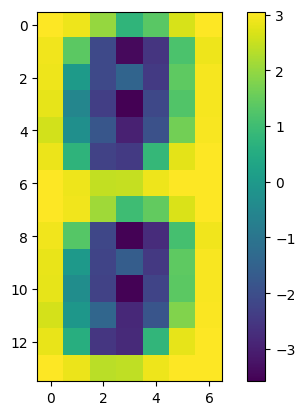

In [ ]:
len_vector=np.sum(mod0_test_x, axis=3)

plt.imshow(len_vector.mean(axis=0))
plt.colorbar()
plt.show()

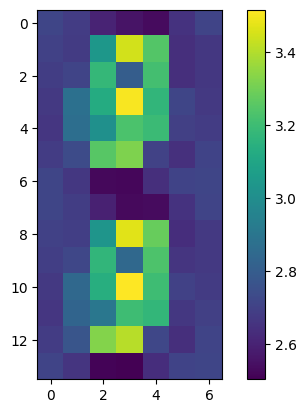

In [ ]:
len_vector=np.linalg.norm(mod0_test_x, axis=3)

plt.imshow(len_vector.mean(axis=0))
plt.colorbar()
plt.show()

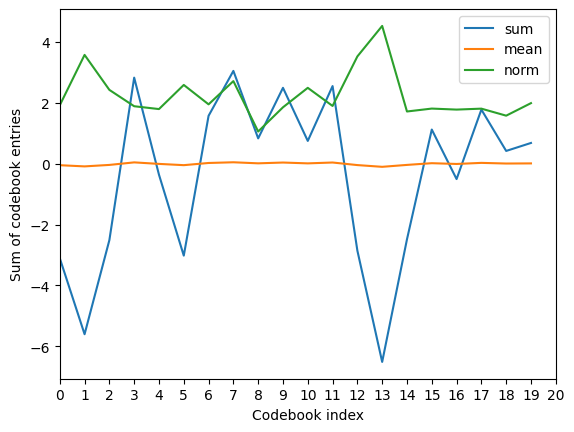

In [ ]:
plt.plot(codebooks.sum(axis=1))
plt.plot(codebooks.mean(axis=1))
plt.plot(np.linalg.norm(codebooks,axis=1))
plt.xlim(0, 20)
plt.legend(['sum', 'mean', 'norm'])
plt.xticks(np.arange(0, 21, 1))
plt.xlabel('Codebook index')
plt.ylabel('Sum of codebook entries')
plt.show()

In [ ]:
codebooks.mean(axis=1)

array([-0.04851075, -0.08754852, -0.03922753,  0.04420979, -0.00564118,
       -0.04718789,  0.02460446,  0.04766742,  0.01302287,  0.03897966,
        0.01171095,  0.03987435, -0.04462614, -0.10177438, -0.03881419,
        0.01754777, -0.00788068,  0.02780522,  0.00656563,  0.0106642 ],
      dtype=float32)

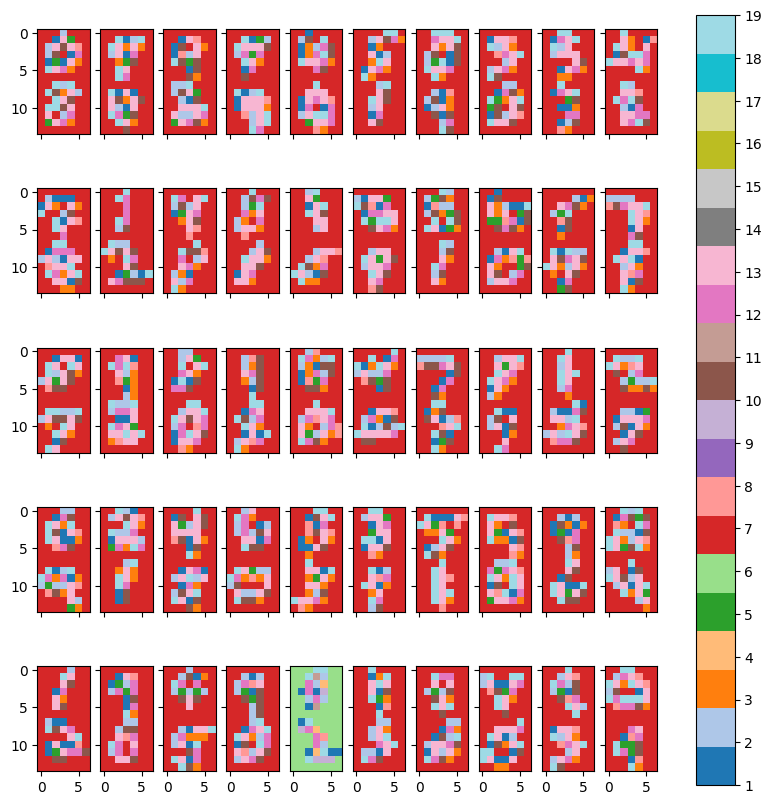

In [ ]:
#plot large plot with 50 samples of mod0_test_x with a shared colorbar
n=50
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 10), sharex=True, sharey=True)
i=0
for ax in axes.flat:
    i+=1
    im = ax.imshow(mod0_test_y[i].reshape(14,7),cmap='tab20')

fig.colorbar(im, ax=axes.ravel().tolist(), ticks=range(0,21))


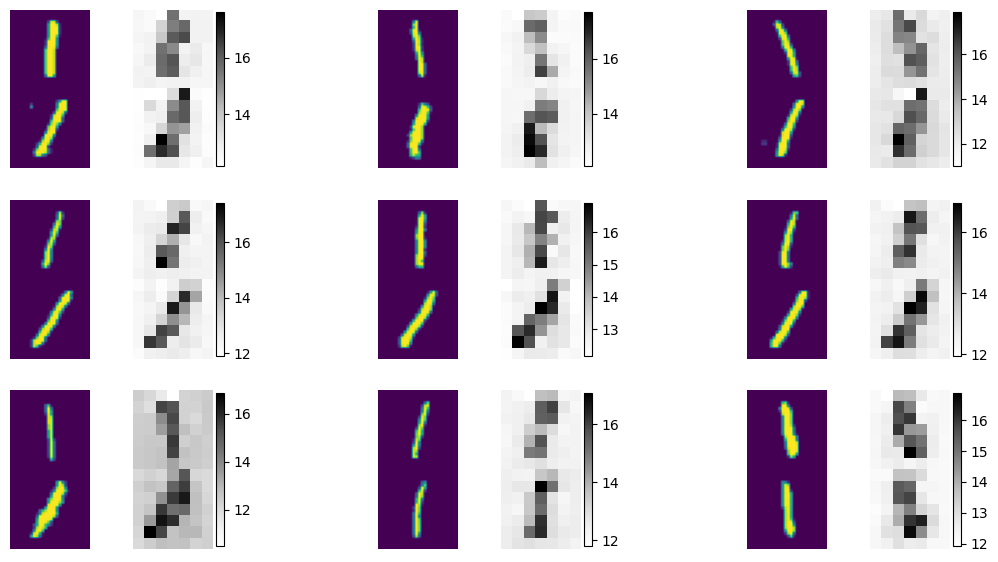

In [ ]:
#plot ten images of the largest _logit values reshaped into (14,7) with a shared colorbar range

n_rec = 9
plt.figure(figsize=(14,7))
for i in range(n_rec):
    plt.subplot(3,n_rec,3*i+1)
    plt.imshow(mod1_x_test[mod1_y_test==11][i].reshape(56,28))
    plt.axis('off')
    plt.subplot(3,n_rec,3*i+2)
    plt.imshow(confidence[i].reshape(14,7),cmap='Greys')
    plt.axis('off')
    plt.colorbar(fraction=0.075, pad=0.04)
    #plt.subplot(3,n_rec,3*i+3)
    #plt.imshow(a[i].reshape(14,7),cmap='RdGy_r')

    plt.axis('off')

plt.show()


In [ ]:
angel=np.zeros((20,20))

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    #return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    return np.dot(v1_u, v2_u)
for i in range(20):
    for j in range(20):
        angel[i,j]= angle_between(codebooks[i],codebooks[j])

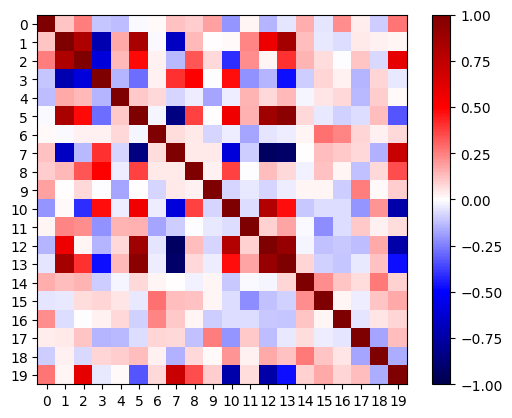

In [ ]:
plt.imshow(angel,cmap='seismic',vmin=-1,vmax=1)
plt.colorbar()


plt.xticks(np.arange(0,20,1))
plt.yticks(np.arange(0,20,1))
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


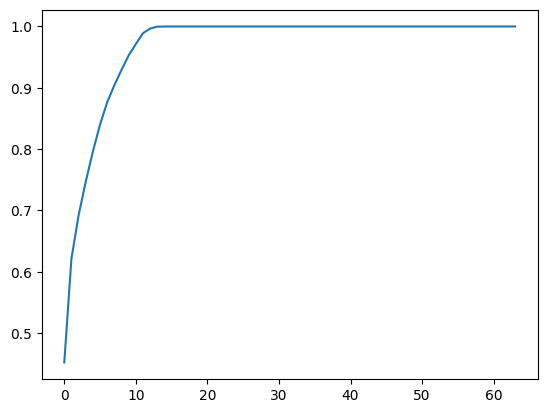

In [ ]:
	data = codebooks


### Step 1: Standardize the Data along the Features
standardized_data = (data - data.mean(axis = 0)) / data.std(axis = 0)


### Step 2: Calculate the Covariance Matrix
# use `ddof = 1` if using sample data (default assumption) and use `ddof = 0` if using population data
covariance_matrix = np.cov(standardized_data, ddof = 1, rowvar = False)


### Step 3: Eigendecomposition on the Covariance Matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)


### Step 4: Sort the Principal Components
# np.argsort can only provide lowest to highest; use [::-1] to reverse the list
order_of_importance = np.argsort(eigenvalues)[::-1]

# utilize the sort order to sort eigenvalues and eigenvectors
sorted_eigenvalues = eigenvalues[order_of_importance]
sorted_eigenvectors = eigenvectors[:,order_of_importance] # sort the columns


### Step 5: Calculate the Explained Variance
# use sorted_eigenvalues to ensure the explained variances correspond to the eigenvectors
explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)


### Step 6: Reduce the Data via the Principal Components
k = 2 # select the number of principal components
reduced_data = np.matmul(standardized_data, sorted_eigenvectors[:,:k]) # transform the original data


### Step 7: Determine the Explained Variance
total_explained_variance = sum(explained_variance[:k])


### Potential Next Steps: Iterate on the Number of Principal Components
plt.plot(np.cumsum(explained_variance))

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1475: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(x))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1477: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:758: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:897: ComplexWarning: Casting comp

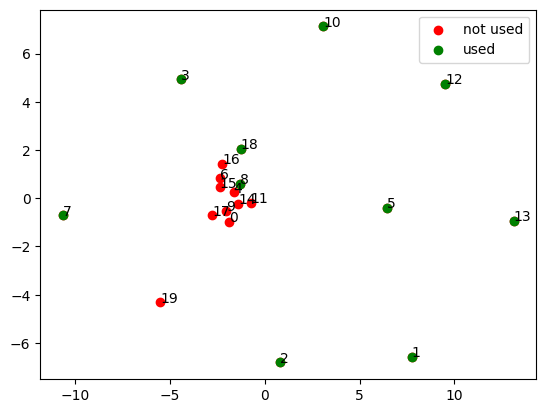

In [ ]:
used=[1,2,3,5,7,8,10,12,13,18]
fig, ax = plt.subplots()

ax.scatter(reduced_data[:,0], reduced_data[:,1],c='r')
ax.scatter(reduced_data[used,0], reduced_data[used,1],c='g')
plt.legend(['not used', 'used'])
for i in range(20):
    ax.annotate(i, (reduced_data[i,0], reduced_data[i,1]))


#plt.scatter(reduced_data[:,0], reduced_data[:,1])

##Check the ambigius data

In [ ]:
(x_train_amb, y_train_amb), (x_test_amb, y_test_amb) = load_data('/content/drive/MyDrive/Data/amb_mnist.npz')

KeyError: 'x_train is not a file in the archive'

In [ ]:
with np.load('/content/drive/MyDrive/Data/amb_data_selected.npz') as f:
        x_amb, y_amb = f['data'], f['labels']


#data=np.load('/content/drive/MyDrive/Data/amb_data_selected.npz')

In [ ]:
x_amb[x_amb<0.3]=0
x_amb[x_amb>0.8]=1


In [ ]:
encoded_outputs = vq_vae.predict(x_amb)
amb_x = encoded_outputs[1][...,1] #Zq

amb_y = encoder.predict(x_amb)



np.save('/content/drive/MyDrive/Data/amb_x.npy',amb_x )
np.save('/content/drive/MyDrive/Data/amb_y.npy',amb_y )
#amb_generated = decoder.predict(encoded_outputs, steps=1)
#np.save('/content/drive/MyDrive/Data/mnist_vqvae_generated.npy',amb_generated )
#amb_preds=classifier.predict(amb_generated)
#np.save('/content/drive/MyDrive/Data/mnist_vqvae_preds.npy',amb_preds )



28/28 [==============================] - 0s 1ms/step


In [ ]:
def unison_shuffled_copies(a, b, c, d):
    assert len(a) == len(b)
    assert len(a) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p], d[p]


sh_amb_x, sh_amb_y, sh_x_amb, sh_y_amb = unison_shuffled_copies(amb_x, amb_y,x_amb, y_amb)
#sh_test_X, sh_test_y,sh_x_test, sh_y_test = unison_shuffled_copies(test_X, test_y,x_test, y_test)

In [ ]:
all_amb_x=np.concatenate((amb_x,sh_amb_x), axis=1)
all_amb_y=np.concatenate((amb_y,sh_amb_y), axis=1)

all_x_amb=np.concatenate((x_amb,sh_x_amb), axis=1)
#all_y_amb=np.concatenate((y_amb,sh_y_amb), axis=1)


In [ ]:
all_labels=np.array(10*y_amb+sh_y_amb)

In [ ]:
n_rec = 877
mod0_masked_test_x = half_mask(all_amb_x[:n_rec],0,0)
# see https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.MaskedLMOutput
reconstructions = model0.predict({'inputs_embeds': mod0_masked_test_x[:n_rec].astype('float32'), 'labels': mod0_test_y[:n_rec].astype('float32')}, batch_size=256)

logits1 = reconstructions.logits
#logits= tf.nn.softmax(logits, axis=-1).numpy()
most_probable1 = logits1.argmax(axis=-1)

confidence1=logits1.max(axis=-1)

4/4 [==============================] - 0s 38ms/step


ValueError: num must be an integer with 1 <= num <= 40, not 41

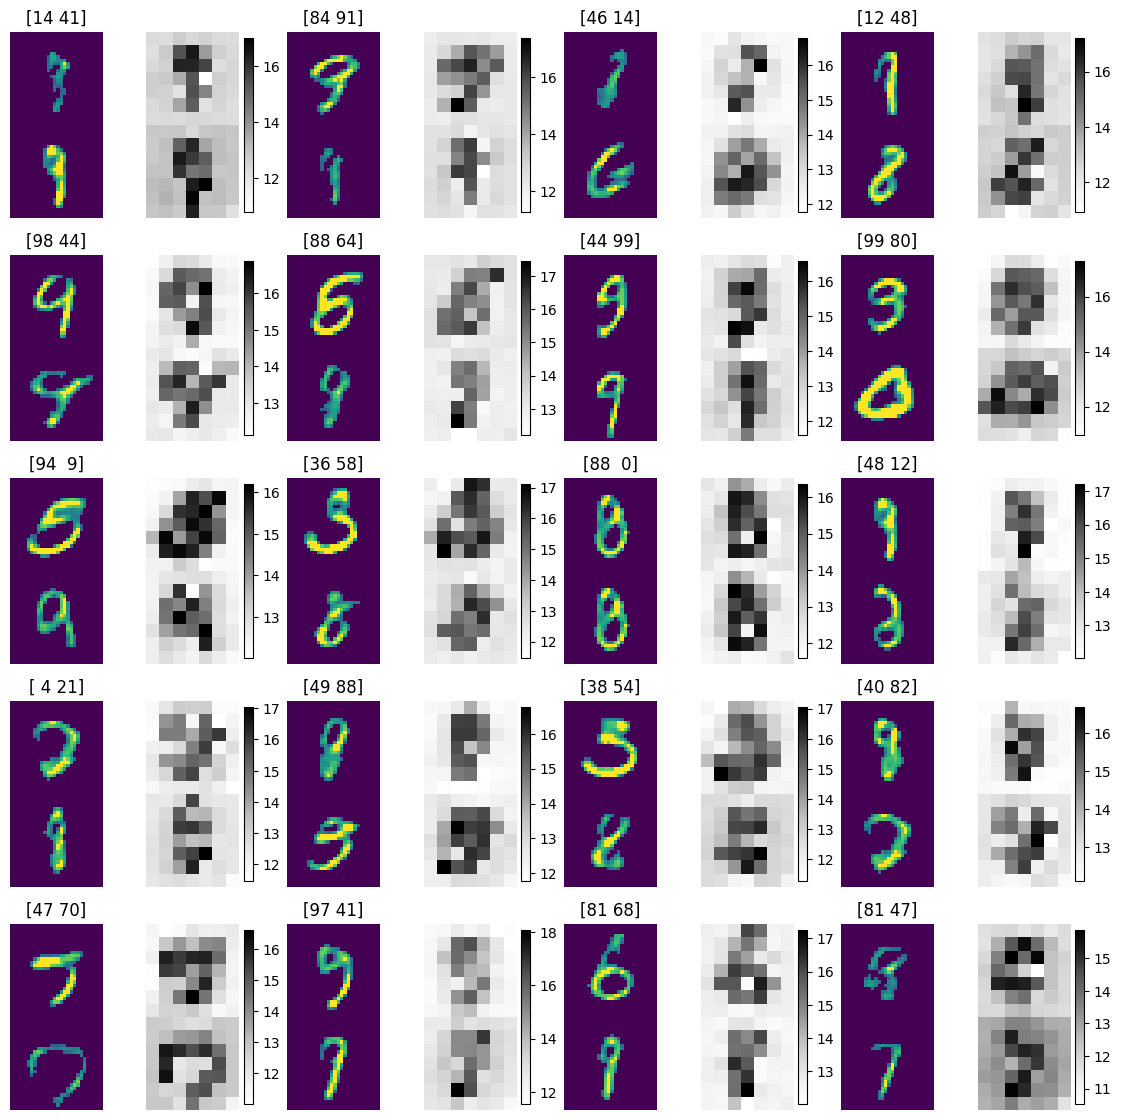

In [ ]:
plt.figure(figsize=(14,14))
for i in range(n_rec):
    plt.subplot(5,8,2*i+1)
    plt.imshow(all_x_amb[i].reshape(56,28))
    plt.axis('off')
    plt.title(str(all_labels[i]))
    plt.subplot(5,8,2*i+2)
    plt.imshow(confidence1[i].reshape(14,7),cmap='Greys')
    plt.axis('off')
    plt.colorbar(fraction=0.075, pad=0.04)



plt.show()

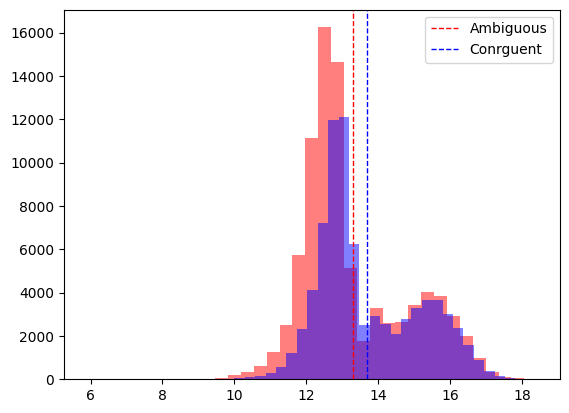

In [ ]:
plt.hist(confidence1.flatten(), 35, alpha=0.5, color='r')
plt.axvline(confidence1.flatten().mean(), color='r', linestyle='dashed', linewidth=1)
plt.hist(confidence.flatten(), 35, alpha=0.5, color='b')
plt.axvline(confidence.flatten().mean(), color='b', linestyle='dashed', linewidth=1)
plt.legend(['Ambiguous', 'Conrguent'])

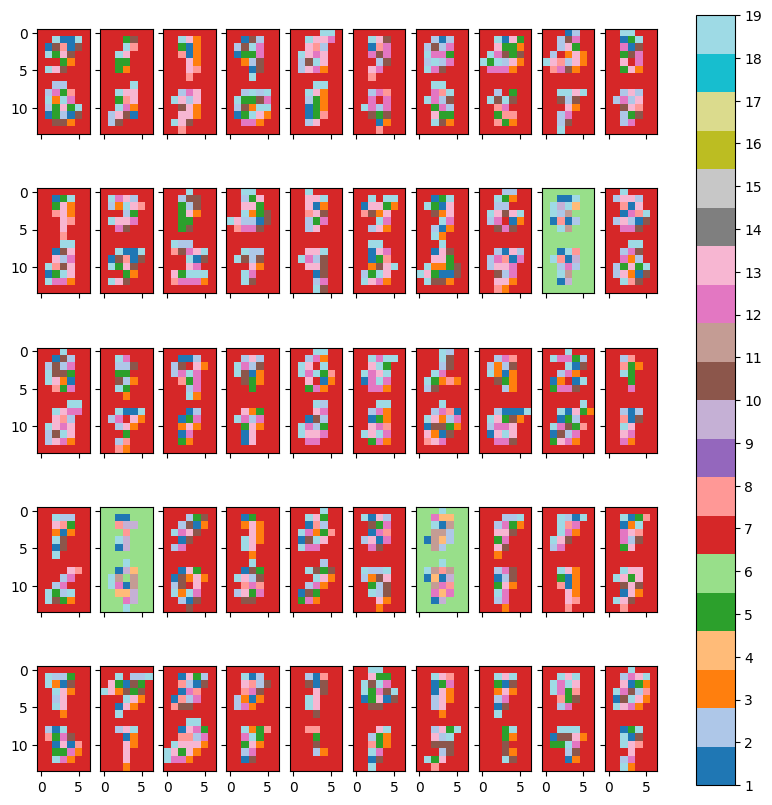

In [ ]:
n=50
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 10), sharex=True, sharey=True)
i=0
for ax in axes.flat:
    i+=1
    im = ax.imshow(all_amb_y[i].reshape(14,7),cmap='tab20')

fig.colorbar(im, ax=axes.ravel().tolist(), ticks=range(0,21))

In [ ]:
print(all_amb_y[0].reshape(14,7))

[[19  8  8  8  8  8  8]
 [19  3  2  5 19  8  8]
 [19  3  8  5 10  8  8]
 [19  8  8  5  8  8  8]
 [19  8  3  8  3  8  8]
 [19  8  8 10  8  8  8]
 [19  8  8  8  8  8  8]
 [19  8  8  3  8  8  8]
 [19  8  8  8  8  8  8]
 [19  8 19  5  8  8  8]
 [19  8  8 10  8  8  8]
 [19  3  8  8  8  8  8]
 [19  8  8  8  3  8  8]
 [19  8  8  8  8  8  8]]


In [ ]:
all_amb_y = all_amb_y.reshape(( all_amb_y.shape[0], n_tokens))

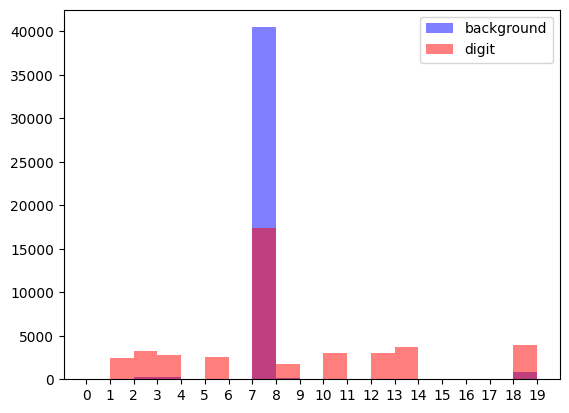

In [ ]:
plt.hist(all_amb_y[:,~digit].flatten(), range(20), alpha=0.5, color='b')
plt.hist(all_amb_y[:,digit].flatten(), range(20), alpha=0.5, color='r')
plt.xticks(np.arange(0, 20, 1))
plt.legend(['background','digit'])
plt.show()

In [ ]:
class1=classifier.predict(x_amb).max(axis=-1)
class2=classifier.predict(sh_x_amb).max(axis=-1)

28/28 [==============================] - 0s 2ms/step


In [ ]:
print(class1)

[0.8656977  0.9976718  0.9941314  0.99053043 0.5393297  0.4986633
 0.97654736 0.69014823 0.4332693  0.8852802  0.48305702 0.9966953
 0.9303048  0.41712296 0.9100463  0.7782798  0.9982717  0.88997775
 0.9997335  0.5565263  0.99856454 0.5908394  0.35000893 0.96523905
 0.9987984  0.9926381  0.5420155  0.99952984 0.780453   0.63416
 0.99951303 0.97516567 0.7624294  0.99810505 0.8010078  0.9438404
 0.71410364 0.83678734 0.99828017 0.90937173 0.90972334 0.6631787
 0.999856   0.99859744 0.99435246 0.6511884  0.99886477 0.49050346
 0.58223313 0.99931514 0.9273497  0.9998336  0.89123315 0.38588956
 0.8672921  0.43464205 0.9982343  0.9997397  0.9452448  0.9973646
 0.7526421  0.71909124 0.95426863 0.98457795 0.9850278  0.9991973
 0.99275607 0.86101985 0.99789846 0.97878426 0.69405013 0.5339105
 0.94430596 0.98678094 0.9983369  0.88385725 0.99594146 0.9543243
 0.85773176 0.60003746 0.9054089  0.70487785 0.99033326 0.9851295
 0.7406804  0.995262   0.94930136 0.99977535 0.8007597  0.9992022
 0.99192

In [ ]:
confup=np.mean(confidence1[:,:49],axis=-1)
confdown=np.mean(confidence1[:,49:],axis=-1)

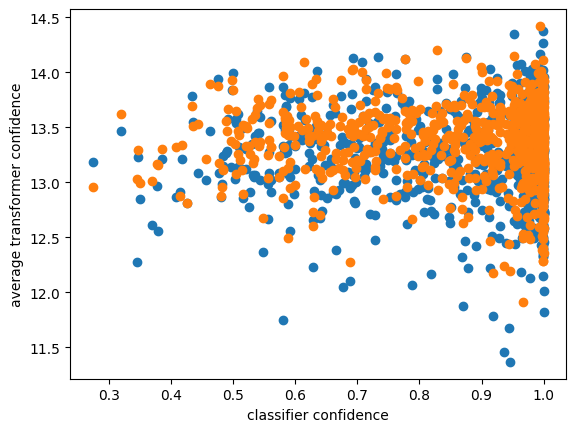

In [ ]:
plt.scatter(class1,confup)
plt.scatter(class2,confdown)
plt.xlabel('classifier confidence')
plt.ylabel('average transformer confidence')
#plt.legend(['Ambiguous', 'Conrguent'])
plt.show()

In [ ]:
confdigitup=np.mean(confidence1[:,digitup],axis=-1)
confdigitdown=np.mean(confidence1[:,digitdown],axis=-1)

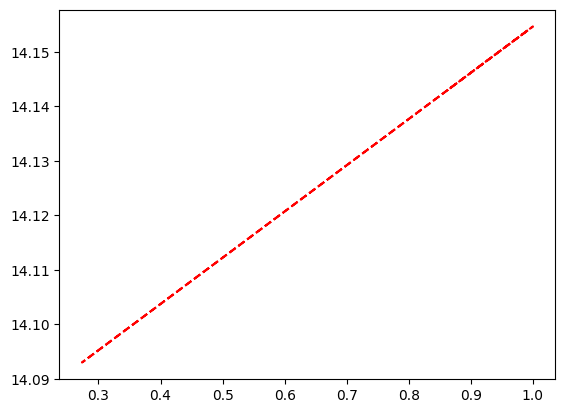

In [ ]:
zup = np.polyfit(class1, confdigitup, 1)
pup = np.poly1d(zup)
plt.plot(class1,pup(class1),"r--")

In [ ]:
zdown = np.polyfit(class1, confdigitdown, 1)
pdown = np.poly1d(zdown)


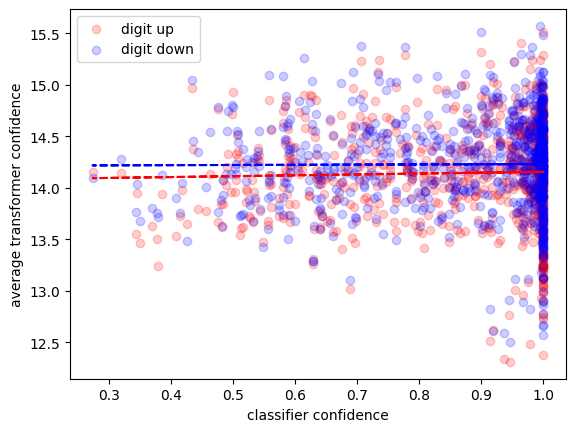

In [ ]:
plt.scatter(class1,confdigitup, color='red',alpha=0.2)
plt.scatter(class2,confdigitdown, color='blue',alpha=0.2)
plt.plot(class1,pup(class1),"r--")
plt.plot(class1,pdown(class1),"b--")

plt.xlabel('classifier confidence')
plt.ylabel('average transformer confidence')
plt.legend(['digit up', 'digit down'])
plt.show()

In [ ]:
largeconf=confidence1>16

In [ ]:
lconfup=np.count_nonzero(largeconf[:,digitup], axis=-1)
lconfdown=np.count_nonzero(largeconf[:,digitdown],axis=-1)



In [ ]:
z = np.polyfit(class1, lconfup, 1)
p = np.poly1d(z)

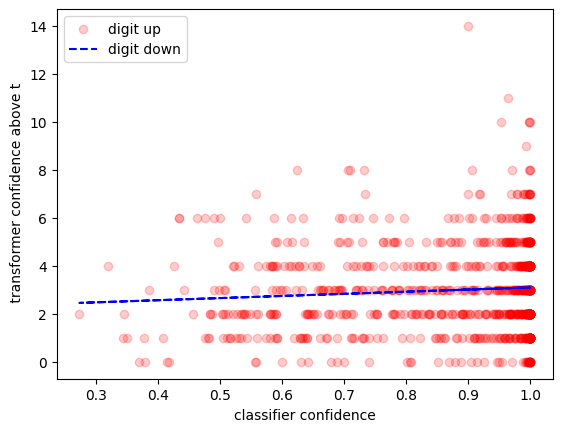

In [ ]:
plt.scatter(class1,lconfup, color='red',alpha=0.2)
#plt.scatter(class2,lconfdown, color='blue',alpha=0.2)
#plt.plot(class1,pup(class1),"r--")
#plt.plot(class1,pdown(class1),"b--")
plt.plot(class1,p(class1),"b--")
plt.xlabel('classifier confidence')
plt.ylabel(' transformer confidence above t')
plt.legend(['digit up', 'digit down'])
plt.show()